# Challenge Large Scale Machine Learning


This challenge takes part of an advance machine learning course (MDI341) at Télécom Paris.

This notebook details the implementation of my participation in the challenge, divided in 6 parts. Each part begins with the implementation used in the best submission I made. The implementations tested but not giving the best result have been left and start by "tested".

The values of the parameters were found after testing and comparing multiple values.

[GitHub repository](https://github.com/xavierbrt/telecom-data-challenge-2) of the project.

## Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import describe
from scipy.stats import rankdata
from scipy.signal import lfilter
from scipy.stats import kurtosis, skew, entropy

from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, maxabs_scale, QuantileTransformer, PowerTransformer

In [0]:
ROOT = "drive/My Drive/Colab Notebooks/Data Challenge 2/"
RANDOM_STATE = 261

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Data loading

In [0]:
%%time

xtrain = np.loadtxt(ROOT + 'data/train.csv', delimiter= ' ')
print("Train:", xtrain.shape)
xtest = np.loadtxt(ROOT + 'data/test.csv', delimiter= ' ')
print("Test:", xtest.shape)

Train: (1677, 61440)
Test: (2511, 61440)
CPU times: user 2min 8s, sys: 14.7 s, total: 2min 22s
Wall time: 2min 30s


-----------
# 2. Data exploration

First, we will display some time series, to have an idea of the kind of time series we have, and the kind of anomalies we can find.

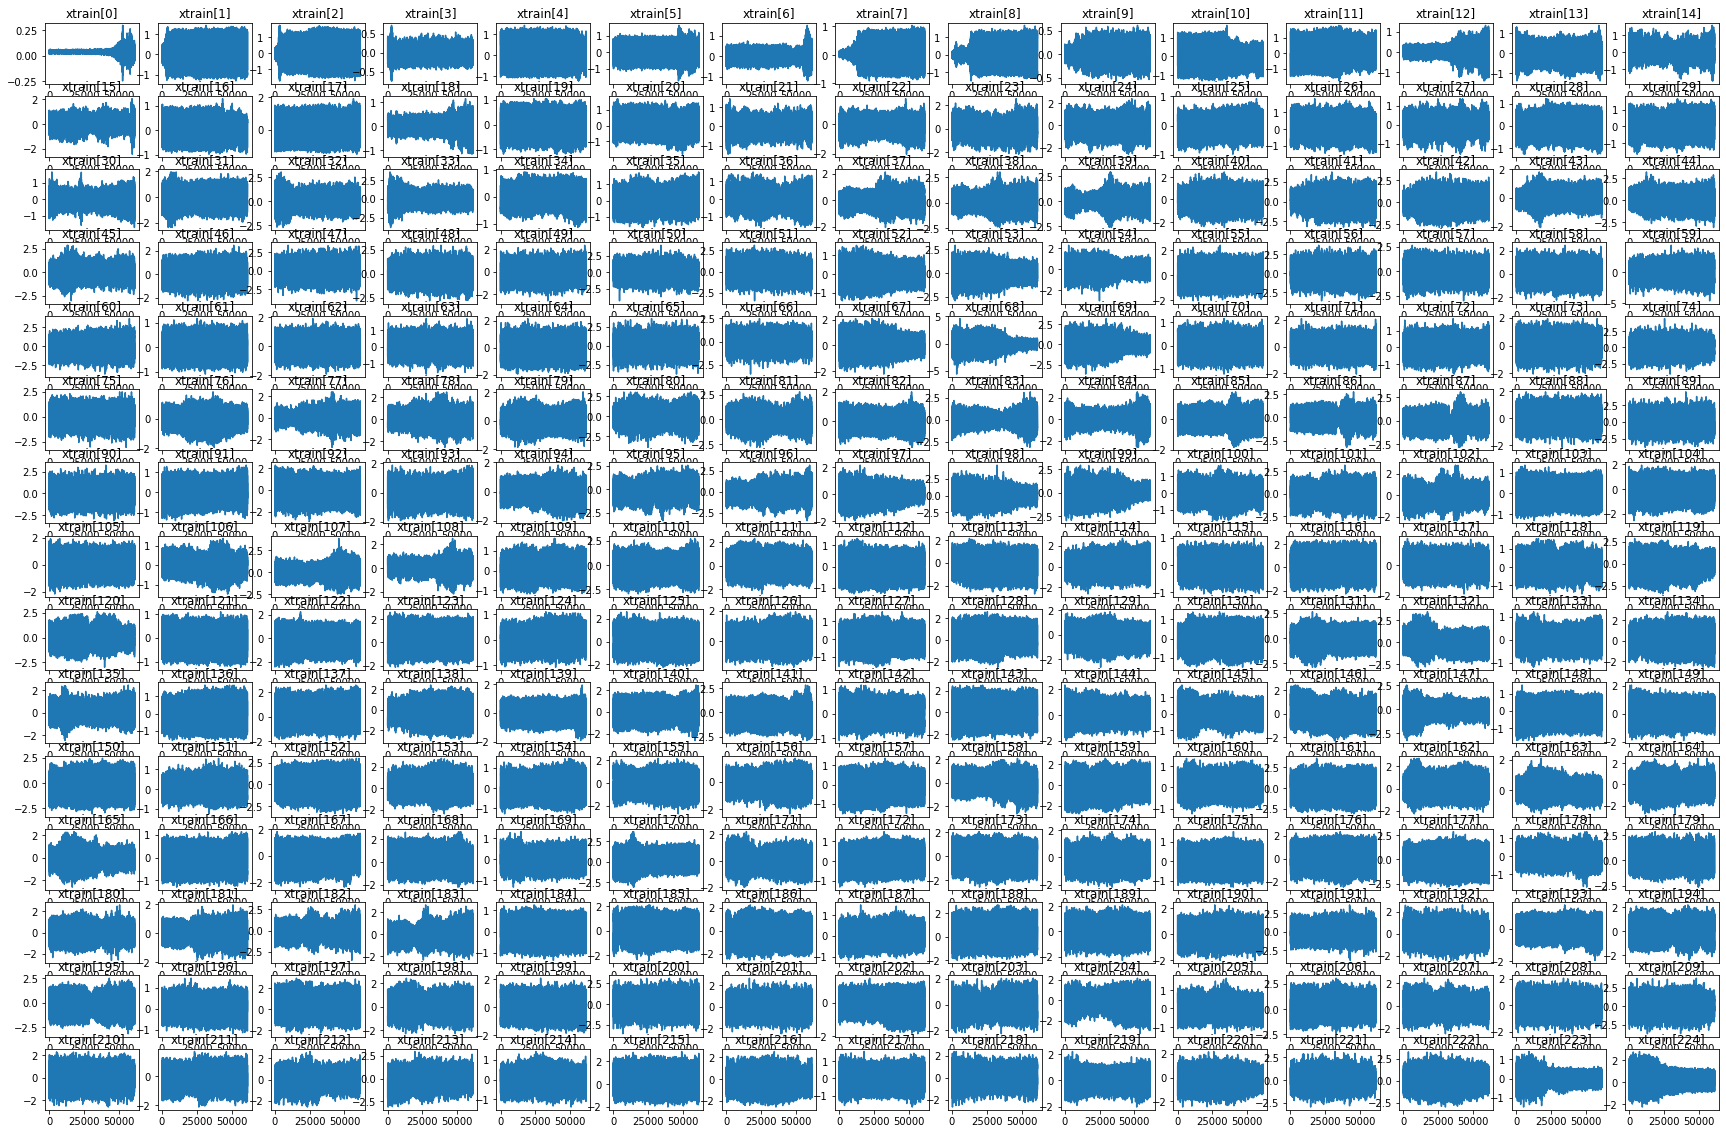

In [0]:
plt.figure(figsize=(30,20))
for i in range(0,225):
  plt.subplot(15,15,i+1)
  ax = plt.plot(xtrain[i])
  plt.title("xtrain[" + str(i) + "]")
plt.show()

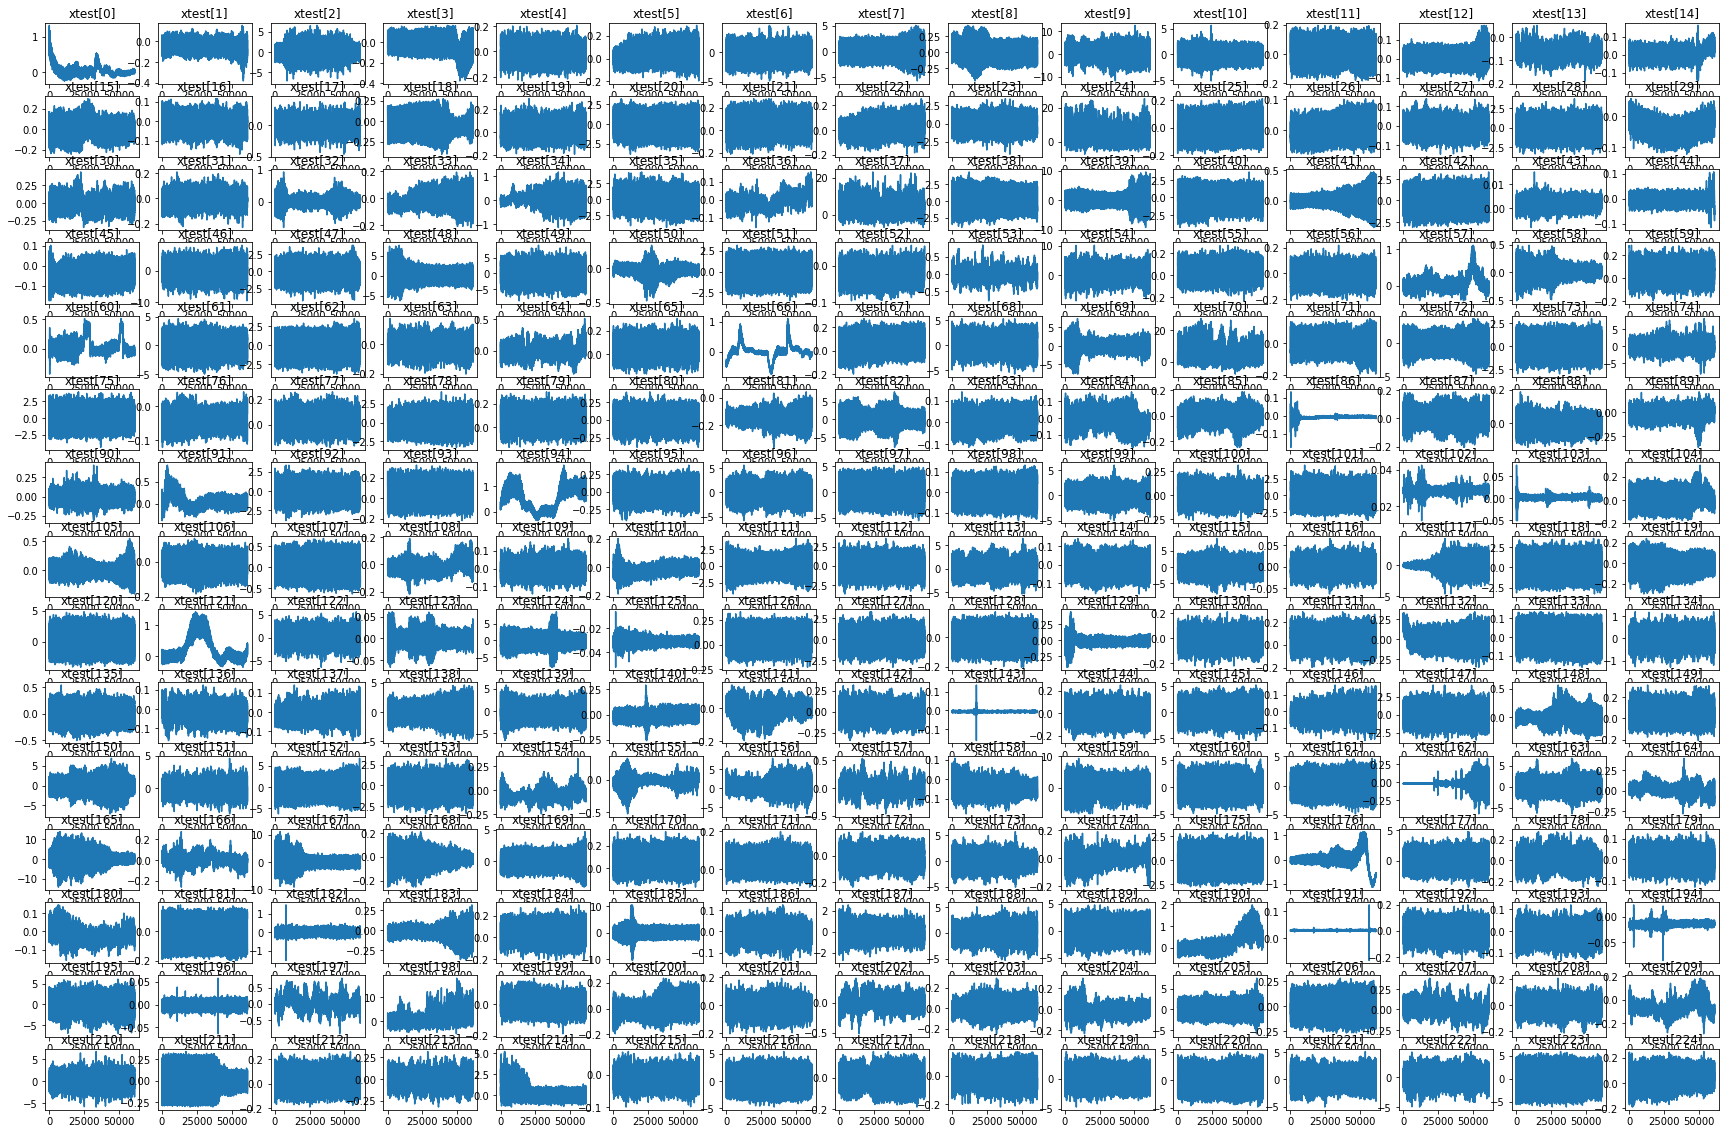

In [0]:
plt.figure(figsize=(30,20))
for i in range(0,225):
  plt.subplot(15,15,i+1)
  ax = plt.plot(xtest[i])
  plt.title("xtest[" + str(i) + "]")
plt.show()

Some observations are really different compared to the others. In order to have a more precise idea of the dataset, I made a script in order to print all of the curves into graphs, and export all of this graphes as png files, in order to explore them all. The script is available on the [GitHub repository](https://github.com/xavierbrt/telecom-data-challenge-2) of the project.

To analyze the difference of the statistics between the train and test sets we compute the statistics and then display the histogram of each, compute the covariance matrix of both and then the statistics of the statistics, to see how they vary.

In [0]:
def compute_stats(xset, isTrain):
  xset_feat = pd.DataFrame(columns=[])
  xset_feat["min"] = np.min(xset, axis=1)
  xset_feat["max"] = np.max(xset, axis=1)
  xset_feat["mean"] = np.mean(xset, axis=1)  
  xset_feat["median"] = np.median(xset, axis=1)
  xset_feat["var"] = np.var(xset, axis=1)
  xset_feat["std"] = np.std(xset, axis=1)
  xset_feat["rms"] = np.mean(np.sqrt(xset**2), axis=1) 

  zero_crossings = []
  for i in range(0, xset.shape[0]):
    zero_crossings_indices = np.nonzero(np.diff(np.array(xset[i,:]) > 0))[0]
    zero_crossings.append(len(zero_crossings_indices))
  xset_feat["zero_crossings"] = PowerTransformer().fit_transform(np.reshape(zero_crossings, (-1, 1)))


  mean_crossings = []
  for i in range(0, xset.shape[0]):
    mean_crossing_indices = np.nonzero(np.diff(np.array(xset[i,:]) > np.nanmean(xset[i,:])))[0]
    mean_crossings.append(len(mean_crossing_indices))
  xset_feat["mean_crossings"] = PowerTransformer().fit_transform(np.reshape(mean_crossings, (-1, 1)))

  if isTrain:
    xset_feat["hurst"] = np.loadtxt(ROOT + 'H_train.csv')
  else:
    xset_feat["hurst"] = np.loadtxt(ROOT + 'H_test.csv')

  entropies = []
  for i in range(0, xset.shape[0]):
    counter_values = Counter(xset[i]).most_common()
    probabilities = [elem[1]/len(xset[i]) for elem in counter_values]
    entropies.append(entropy(probabilities))
  xset_feat["entropy"] = entropies
  
  xset_feat["etendue"] = xset_feat["max"] - xset_feat["min"]
  xset_feat["skewness"] = skew(xset, axis=1)
  xset_feat["kurtosis"] = StandardScaler().fit_transform(np.reshape(kurtosis(xset, axis=1), (-1, 1)))
  
  percentiles = np.percentile(xset, [10,30,50,70,90], axis=1)
  xset_feat["10"] = percentiles[0]
  xset_feat["30"] = percentiles[1]
  xset_feat["50"] = percentiles[2]
  xset_feat["70"] = percentiles[3]
  xset_feat["90"] = percentiles[4]

  return xset_feat

In [0]:
xtrain_feat = compute_stats(xtrain, True) 
xtrain_feat.head()

xtest_feat = compute_stats(xtest, False) 
xtest_feat.head()

min       max      mean  ...        50        70        90
0 -0.246444  1.320870  0.052278  ...  0.012854  0.067152  0.220514
1 -0.384193  0.157110 -0.044933  ... -0.043788 -0.013863  0.024425
2 -7.058065  6.521087 -0.025039  ... -0.020552  0.687530  1.775638
3 -0.377841  0.161022 -0.019569  ... -0.013400  0.041738  0.083257
4 -0.231434  0.205329 -0.014652  ... -0.015026  0.014698  0.056158

[5 rows x 19 columns]

In [0]:
stats = xtrain_feat.columns

plt.figure(figsize=(30,6*len(stats)))
for index, stat in enumerate(stats):
  #xtrain
  plt.subplot(len(stats), 2, 2*index+1)
  plt.hist(xtrain_feat[stat], bins="auto", log=True)
  plt.title("xtrain - " + stat)
  plt.xticks(range(-35,35,5))
  #xtest
  plt.subplot(len(stats), 2, 2*index+2)
  plt.hist(xtest_feat[stat], bins="auto", log=True)
  plt.title("xtest - " + stat)
  plt.xticks(range(-35,35,5))
plt.show()

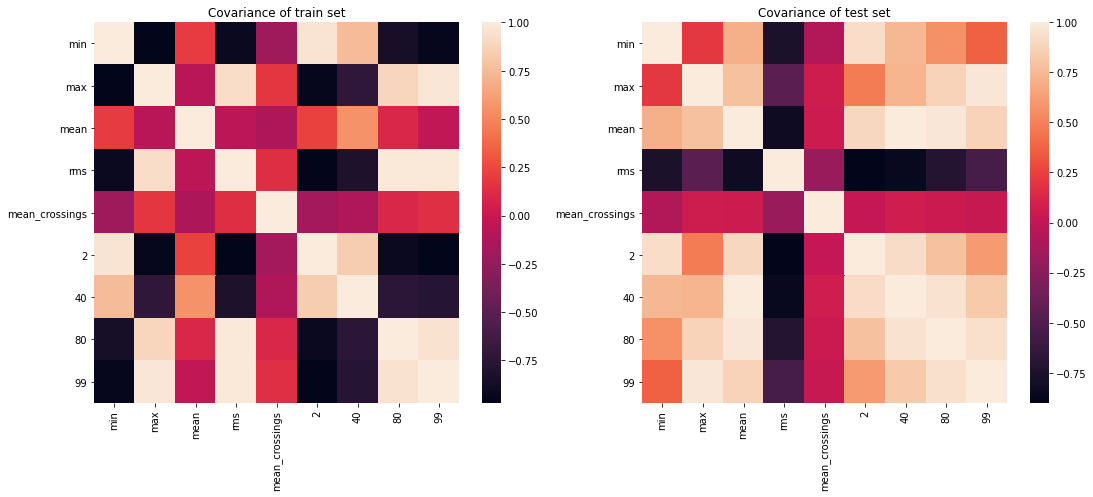

In [0]:
plt.figure(figsize=(18,7))

plt.subplot(121)
corr_train = xtrain_feat.corr()
sns.heatmap(corr_train, 
        xticklabels=corr_train.columns,
        yticklabels=corr_train.columns)
plt.title("Covariance of train set")

plt.subplot(122)
corr_test = xtest_feat.corr()
sns.heatmap(corr_test, 
        xticklabels=corr_test.columns,
        yticklabels=corr_test.columns)
plt.title("Covariance of test set")
plt.show()

In [0]:
xtrain_feat.describe()

min          max  ...           80           99
count  1677.000000  1677.000000  ...  1677.000000  1677.000000
mean     -2.427798     2.432737  ...     0.564088     1.414784
std       2.338362     2.205753  ...     0.593749     1.371907
min     -19.072340     0.128067  ...    -0.006207     0.075532
25%      -3.205512     0.824289  ...     0.170722     0.438118
50%      -1.923143     1.934920  ...     0.460180     1.116817
75%      -0.778349     3.276126  ...     0.786233     1.939622
max      -0.002468    17.914855  ...     6.856062    13.497971

[8 rows x 9 columns]

In [0]:
xtest_feat.describe()

min          max  ...           80           99
count  2511.000000  2511.000000  ...  2511.000000  2511.000000
mean     -3.343300     1.913997  ...    -0.108303     0.854466
std       5.766207     6.688616  ...     4.866879     5.742899
min     -35.742439   -32.692194  ...   -32.747368   -32.722846
25%      -4.538636     0.191429  ...     0.028774     0.103154
50%      -0.584556     0.492111  ...     0.096818     0.261071
75%      -0.204122     3.621896  ...     0.771975     1.974415
max       9.714832    34.015848  ...    34.015848    34.015848

[8 rows x 9 columns]

--------------
# 3. Data preparation

## 3.1. Rolling average

As the accelerometers produce data with noise, we will reduce it by smoothing the curve. To do so, we will do a rolling average, with a window of size 1000.

In [0]:
# The larger n is, the smoother the curve will be
n = 1000  
b = [1.0 / n] * n
a = 1

In [0]:
xtrain_rolling = xtrain.copy()
for i in range(xtrain.shape[0]):
  xtrain_rolling[i] = lfilter(b, a, xtrain[i,:])

xtest_rolling = xtest.copy()
for i in range(xtest.shape[0]):
  xtest_rolling[i] = lfilter(b, a, xtest[i,:])

We will not use the first and the last 1000 points of the curves, because the average rolling is not viable at the extrimities of the curve.

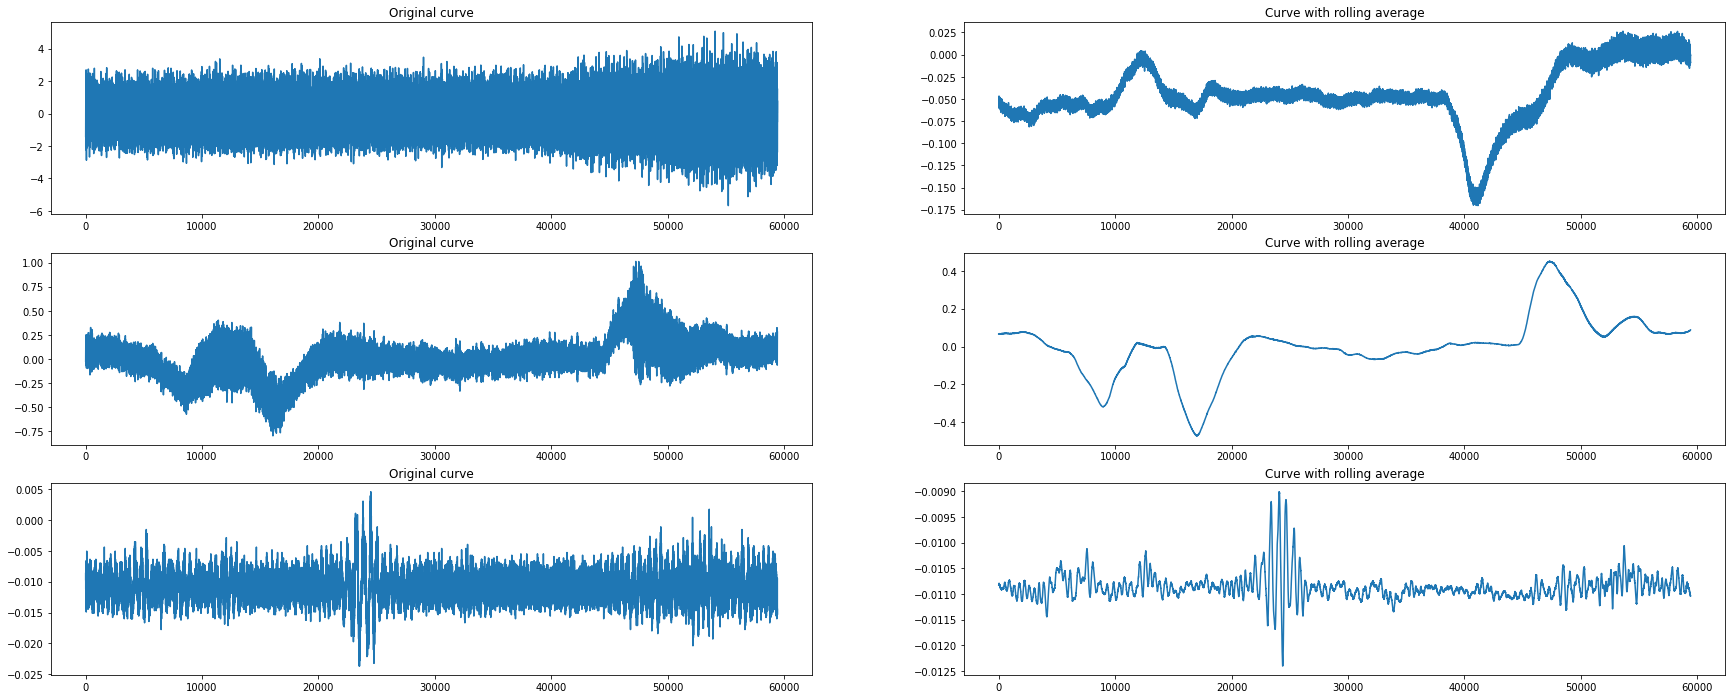

In [0]:
observations = [7, 384, 1091]
plt.figure(figsize=(30,12))

for index, observation in enumerate(observations): 
  plt.subplot(3,2,2*index+1)
  plt.title("Original curve")
  plt.plot(xtest[observation,1000:-1000])
  plt.subplot(3,2,2*index+2)
  plt.title("Curve with rolling average")
  plt.plot(xtest_rolling[observation,1000:-1000])
plt.show()

We can see that the average rolling is efficient to have a cleaner curve and a better idea of the variations. We also note that the frequency vary between curves. **Analyzing the frequency can be a way to detect anomalies !**

## 3.2. PCA

As the observations are in a high dimension, we will project the data on a low-dimensional space with a PCA.

The PCA is not really adapted to time series, because PCA uses linear algebra to transform data. This is why the fonctional analysis gives better results. But it is a good first approach.

### Find the optimal number of eigenvalues

Shape of covariance matrix: (1677, 1677)


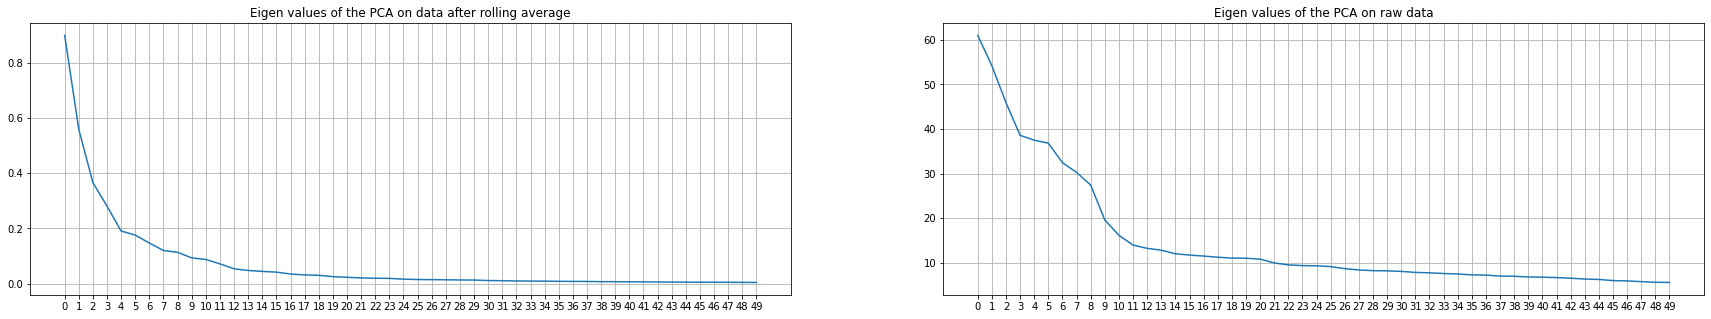

In [0]:
# Compute the covariance matrix
cov_matrix = np.cov(xtrain_rolling[:,1000:-1000])
v, d, vt = np.linalg.svd(cov_matrix)
print("Shape of covariance matrix:", cov_matrix.shape)

cov_matrix_raw_data = np.cov(xtrain)
v_raw, d_raw, vt_raw = np.linalg.svd(cov_matrix_raw_data)

# Display the eigen values
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.plot(d[:50])
plt.title("Eigen values of the PCA on data after rolling average")
plt.grid()
plt.xticks(range(50))

plt.subplot(1,2,2)
plt.plot(d_raw[:50])
plt.title("Eigen values of the PCA on raw data")
plt.xticks(range(50))
plt.grid()

plt.show()

We note that the PCA performed on the data transformed with the rolling average gives better eigen values, with less eigen values needed to well represent the data. **We will keep 4 eigen values for the PCA**.

### PCA transformation

We perform the PCA transformation with the Scikit-lean implementation ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). We first fit the PCA and then apply the transformation to the train and the test datasets.

In [0]:
%%time
# PCA model
pca = PCA(n_components = 4, whiten=True, random_state=RANDOM_STATE)
pca.fit(xtrain_rolling[:,1000:-1000]) 

# PCA transform
xtrain_pca = pca.transform(xtrain_rolling[:,1000:-1000]) 
xtest_pca = pca.transform(xtest_rolling[:,1000:-1000]) 
print(xtrain_pca.shape)

(1677, 4)
CPU times: user 10.6 s, sys: 1.43 s, total: 12.1 s
Wall time: 4.09 s


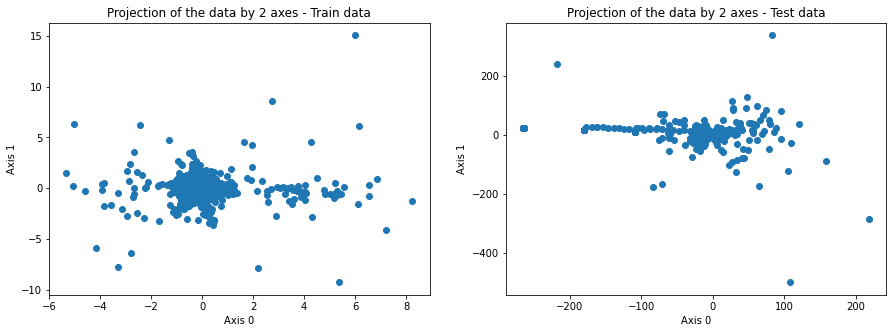

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(xtrain_pca[:,0], xtrain_pca[:,1])
plt.title("Projection of the data by 2 axes - Train data")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

plt.subplot(1,2,2)
plt.scatter(xtest_pca[:,0], xtest_pca[:,1])
plt.title("Projection of the data by 2 axes - Test data")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

plt.show()

The scale of the axis are not the same at all. This may means that the PCA is efficient to separate the data.

## 3.3. Feature set

We will compute some statistics to describe each observations. The goal is to perform a functional analysis.

Based on the data observation, we will compute these features:
* min
* max
* mean
* root mean square value (rms): which is the square of the average of the squared amplitude values)
* mean crossings: the number of time the curve cross the mean of the observation. This is a measure giving a good idea of the frequency of the curve.
* some percentiles : 2%, 40%, 80%, 99%. 2% and 99% can look like too close to the minimum and maximum, but in this way they represent well the extremes, which can be characteristic of anomalies.

In [0]:
def compute_features(xset, isTrain):
  xset_feat = pd.DataFrame(columns=[])
  xset_feat["min"] = np.min(xset, axis=1)
  xset_feat["max"] = np.max(xset, axis=1)
  xset_feat["mean"] = np.mean(xset, axis=1)  
  # Root Mean Square value; square of the average of the squared amplitude values
  xset_feat["rms"] = np.mean(np.sqrt(xset**2), axis=1) 

  mean_crossings = []
  for i in range(0, xset.shape[0]):
    mean_crossing_indices = np.nonzero(np.diff(np.array(xset[i,:]) > np.nanmean(xset[i,:])))[0]
    mean_crossings.append(len(mean_crossing_indices))
  # As the values of the mean crossings are really high, we scale them wih the PowerTransformer, in order to make the data more Gaussian-like.
  # PowerTransformer was choosen thanks to this article: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
  xset_feat["mean_crossings"] = PowerTransformer().fit_transform(np.reshape(mean_crossings, (-1, 1)))
  
  percentiles = np.percentile(xset, [2,10,20,30,40,50,60,70,80,90,99], axis=1)
  xset_feat["2"] = percentiles[0]
  xset_feat["40"] = percentiles[4]
  xset_feat["80"] = percentiles[8]
  xset_feat["99"] = percentiles[10]

  """ Other statistics tested
  xset_feat["median"] = np.median(xset, axis=1)
  xset_feat["var"] = np.var(xset, axis=1)
  xset_feat["std"] = np.std(xset, axis=1)
  xset_feat["etendue"] = xset_feat["max"] - xset_feat["min"]

  xset_feat["skewness"] = skew(xset, axis=1)
  xset_feat["kurtosis"] = StandardScaler().fit_transform(np.reshape(kurtosis(xset, axis=1), (-1, 1)))

  zero_crossings = []
  for i in range(0, xset.shape[0]):
    zero_crossings_indices = np.nonzero(np.diff(np.array(xset[i,:]) > 0))[0]
    zero_crossings.append(len(zero_crossings_indices))
  xset_feat["zero_crossings"] = PowerTransformer().fit_transform(np.reshape(zero_crossings, (-1, 1)))

  # Hurst
  if isTrain:
    xset_feat["hurst"] = np.loadtxt(ROOT + 'H_train.csv')
  else:
    xset_feat["hurst"] = np.loadtxt(ROOT + 'H_test.csv')

  entropies = []
  for i in range(0, xset.shape[0]):
    counter_values = Counter(xset[i]).most_common()
    probabilities = [elem[1]/len(xset[i]) for elem in counter_values]
    entropies.append(entropy(probabilities))
  xset_feat["entropy"] = entropies
  """

  return xset_feat

We compute the statistics on the raw dataset, not the data transformed by the rolling average. We will have more precise results with the raw dataset, as it keeps the initial frequency, extremas, etc.

In [0]:
xtrain_feat = compute_features(xtrain, True) 
xtrain_feat.head()

min       max      mean  ...        40        80        99
0 -0.247552  0.299668  0.039373  ...  0.036916  0.047773  0.122690
1 -1.295304  1.423423  0.003725  ... -0.290982  0.736141  1.171528
2 -1.745115  1.748343  0.012775  ... -0.301253  0.929581  1.449242
3 -0.748198  0.717880  0.004919  ... -0.030318  0.123436  0.349737
4 -1.213873  1.402794  0.032258  ... -0.308354  0.757856  1.140041

[5 rows x 9 columns]

In [0]:
xtest_feat = compute_features(xtest, False) 
xtest_feat.head()

min       max      mean  ...        40        80        99
0 -0.246444  1.320870  0.052278  ... -0.007314  0.110634  0.690354
1 -0.384193  0.157110 -0.044933  ... -0.059191  0.003081  0.069313
2 -7.058065  6.521087 -0.025039  ... -0.370262  1.123856  3.476129
3 -0.377841  0.161022 -0.019569  ... -0.042178  0.062607  0.117966
4 -0.231434  0.205329 -0.014652  ... -0.029176  0.032467  0.111878

[5 rows x 9 columns]

## 3.4. Concatenate PCA and feature columns

We concatenate the dataset comin from the PCA transformation and the one with the statistics information:

In [0]:
print("Initial shapes:")
print(xtrain_pca.shape)
print(xtrain_feat.shape)

print("\nFinal shapes:")
xtrain_pca_feat = np.concatenate((xtrain_pca, xtrain_feat), axis=1)
print(xtrain_pca_feat.shape)

xtest_pca_feat = np.concatenate((xtest_pca, xtest_feat), axis=1)
print(xtest_pca_feat.shape)

Initial shapes:
(1677, 4)
(1677, 9)

Final shapes:
(1677, 13)
(2511, 13)


## 3.5. Other methods tested

### 3.5.1 Vertical flipping

It is assumed that the accelerometers can be placed in either direction between several helicopters and therefore that the measured vibrations have the same meaning in either direction. This is a data augmentation. This does not improve the result.

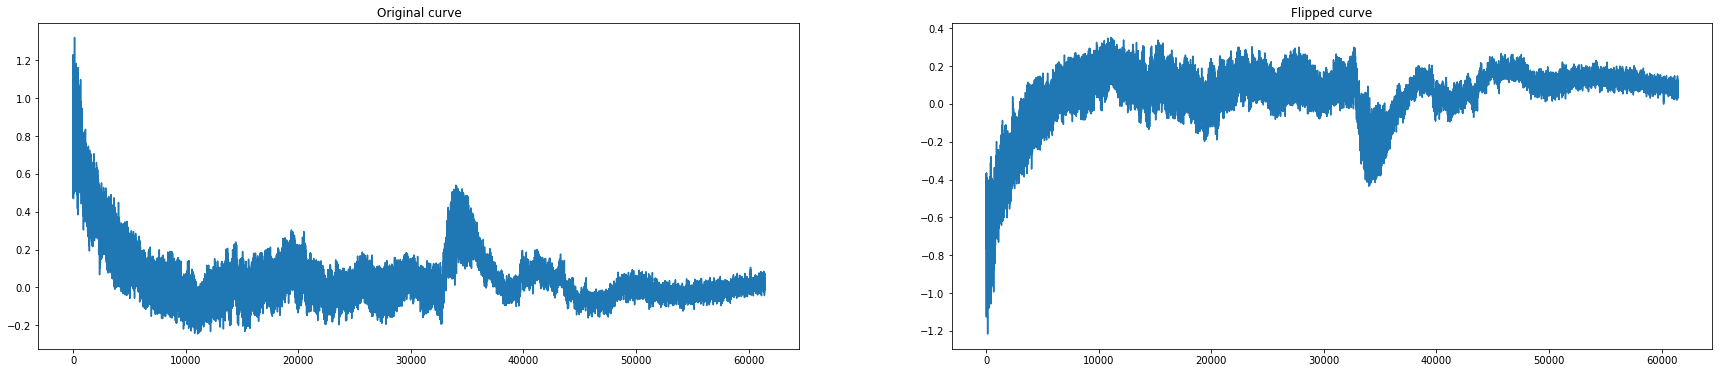

In [0]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
plt.title("Original curve")
plt.plot(xtest[0,:])

plt.subplot(1,2,2)
plt.title("Flipped curve")
plt.plot(xtest[0,:] + 2 * (np.mean(xtest[0,:]) - xtest[0,:]))

plt.show()

In [0]:
# Flip all the curves
xtrain_flip = xtrain.copy()
for i in range(xtrain_flip.shape[0]):
  xtrain_flip[i] =  xtrain_flip[i,:] + 2 * (np.mean(xtrain_flip[i,:]) - xtrain_flip[i,:])
xtrain_flip = np.concatenate((xtrain, xtrain_flip), axis = 0)
xtrain_flip.shape

xtest_flip = xtest.copy()
for i in range(xtest_flip.shape[0]):
  xtest_flip[i] =  xtest_flip[i,:] + 2 * (np.mean(xtest_flip[i,:]) - xtest_flip[i,:])
xtest_flip = np.concatenate((xtest, xtest_flip), axis = 0)
xtest_flip.shape

(3354, 61440)

After having computed the score, separate it here:

In [0]:
df_submissions = pd.DataFrame()
df_submissions["normal"] = sscore_flip[:2511]
df_submissions["flip"] = sscore_flip[2511:]
print(df_submissions.shape)
sscore = np.max(df_submissions, axis=1) # or np.max()
sscore.shape

### 3.5.2. Scaler

We scale the observations, in order for them to evolve in the same range of values. We try different scalers. We must be careful that the scalers does not change the variance of our data.

The scaling does not improve the results. We can assume that the observations having values in ranges far from the others must be anomalies.

Classical scaling: We remove the mean, and divide the values by the difference between the maximum and the mean.

In [0]:
xtrain_scaled = np.empty([xtrain.shape[0], xtrain.shape[1]])
for i in range(xtrain.shape[0]):
  if (np.max(xtrain[i]) - np.mean(xtrain[i])) == 0:
    xtrain_scaled[i] = 0
  else:
    xtrain_scaled[i] = (xtrain[i] - np.mean(xtrain[i])) / (np.max(xtrain[i]) - np.mean(xtrain[i]))

xtest_scaled = np.empty([xtest.shape[0], xtest.shape[1]])
for i in range(xtest.shape[0]):
  if (np.max(xtest[i]) - np.mean(xtest[i])) == 0:
    xtest_scaled[i] = 0
  else:
    xtest_scaled[i] = (xtest[i] - np.mean(xtest[i])) / (np.max(xtest[i]) - np.mean(xtest[i]))

Other scaling methods, provided by Scikit-Learn:

In [0]:
# Scalers tested: Normalizer, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler, maxabs_scale, QuantileTransformer
transformer = StandardScaler()

xtrain_scaled = np.empty([xtrain.shape[0], xtrain.shape[1]])
for i in range(xtrain.shape[0]):
  xtrain_scaled[i] = transformer.fit_transform(xtrain[i].reshape(1, -1))

xtest_scaled = np.empty([xtest.shape[0], xtest.shape[1]])
for i in range(xtest.shape[0]):
  xtest_scaled[i] = transformer.fit_transform(xtest[i].reshape(1, -1))

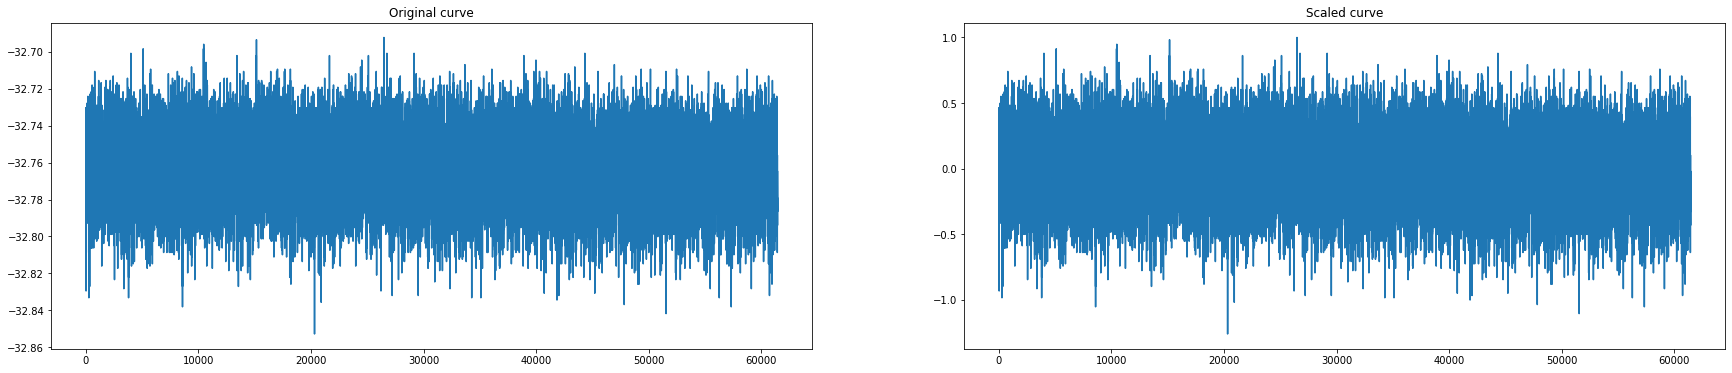

In [0]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
plt.title("Original curve")
plt.plot(xtest[2125,:])

plt.subplot(1,2,2)
plt.title("Scaled curve")
plt.plot(xtest_scaled[2125,:])

plt.show()

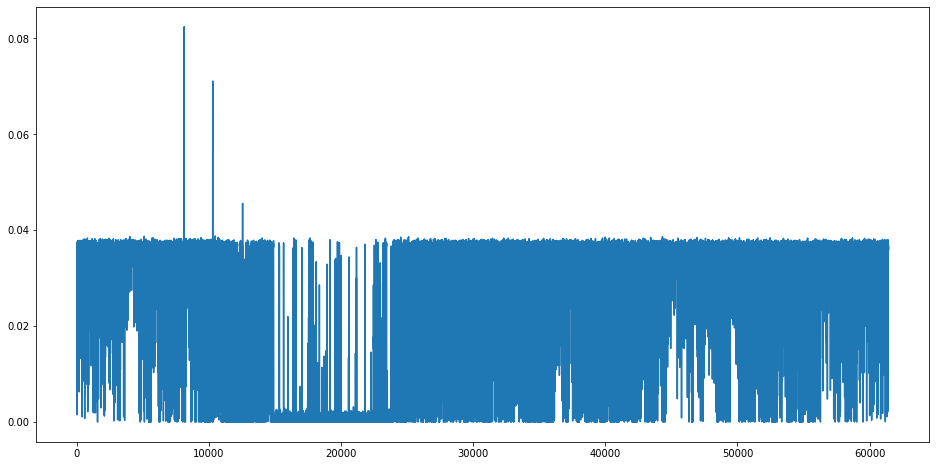

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest_scaled[2125,:]) #2272
plt.show()

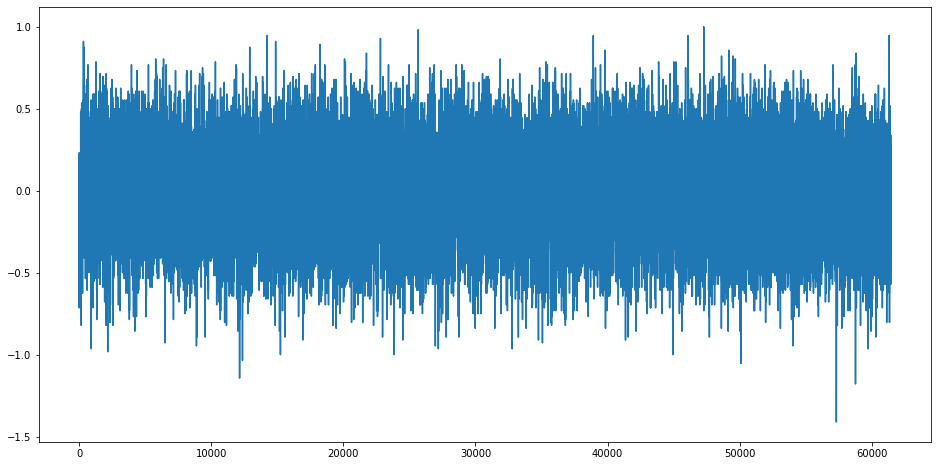

In [0]:
plt.figure(figsize=(16,8))
plt.plot(xtest_scaled[2272,:])
plt.show()

### 3.5.3. Rebin

In the same idea as the rolling average, we smooth the curve and we decrease the dimension, by keeping one value out of 10. To do that, we compute the values we keep by doing the mean of the values of the curves, by batches of 10 values. This process if useful for models that new few dimensions such that the autoencoder, but give poorer results with the other models, as we loose information.

In [0]:
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

xtrain_rebin = rebin(xtrain[:,:-40], (xtrain.shape[0], 614)) # [:,:-40] to divide the number of values by 10 and have no remaining
print("xtrain shape: ", xtrain_rebin.shape)

xtest_rebin = rebin(xtest[:,:-40], (xtest.shape[0], 614))
print("xtest shape: ", xtest_rebin.shape)

xtrain shape:  (1677, 614)
xtest shape:  (2511, 614)


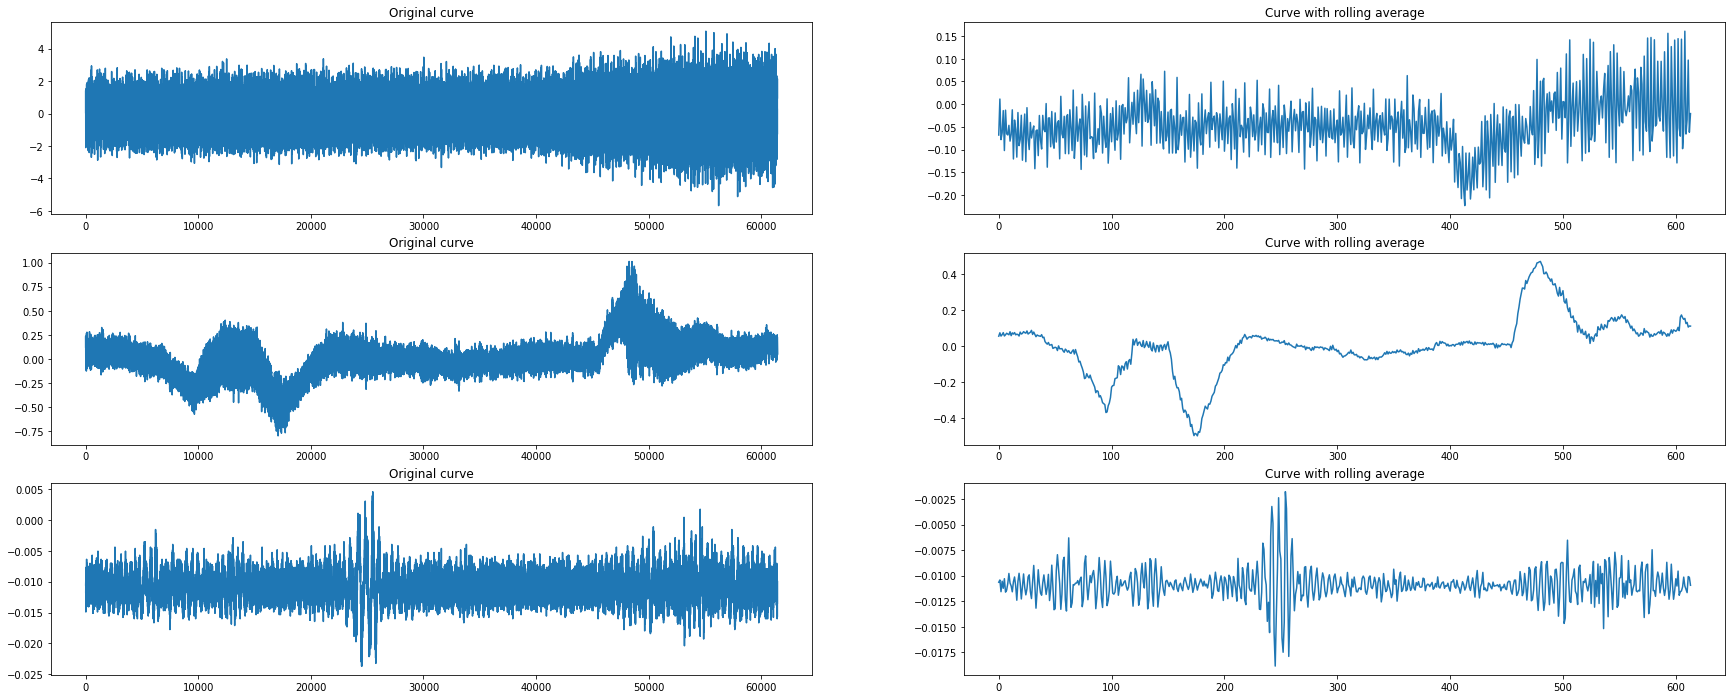

In [0]:
observations = [7, 384, 1091]
plt.figure(figsize=(30,12))

for index, observation in enumerate(observations): 
  plt.subplot(3,2,2*index+1)
  plt.title("Original curve")
  plt.plot(xtest[observation,:])
  plt.subplot(3,2,2*index+2)
  plt.title("Curve with rolling average")
  plt.plot(xtest_rebin[observation,:])
plt.show()

### 3.5.4. xtrain without outliers

We noticed that the first LOF models, computed on the first 100 values of xtrain gave better results that with the overall dataset. We conclude that some observations must be too far from the common observations and be considered as outliers. We will remove from xtrain the observations considered by a LOF to be the more abnomal.

In [0]:
model_lof = LocalOutlierFactor(n_neighbors = 5, contamination = 'auto', novelty = False)
model_lof.fit(xtrain_feat)
score_xtrain = -model_lof.negative_outlier_factor_ 
print(score_xtrain[:10])

[1.47066343 1.27358195 1.03568676 1.03941847 1.28422934 1.12340169
 1.08438302 1.07021639 0.97474429 1.05028469]


In [0]:
df_res2 = pd.DataFrame()
df_res2["index"] = np.argsort(-score_xtrain)
df_res2["score"] = -np.sort(-score_xtrain)

# We keep the 677 most "normal" values
list_indexes = df_res2[df_res2["index"] < xtrain_feat.shape[0]-1000]["index"].to_list()
xtrain_without_outliers = np.take(xtrain, list_indexes, axis=0)
xtrain_without_outliers.shape

(677, 61440)

### 3.5.5. Concatenate train and test

We concatenate the train and test sets, in order to train the model on a larger dataset.

In [0]:
print(xtrain.shape)
print(xtest.shape)
xconcat = np.concatenate((xtrain, xtest), axis = 0)
xconcat.shape

(1677, 61440)
(2511, 61440)


(4188, 61440)

After having computing a score on all the concatenated dataset, we extract the score of the test data:

In [0]:
sscore = sscore[xtrain.shape[0]:]

### 3.5.6. Slice timeseries

We slice the timeseries in three parts, which makes parts of 20 seconds, we train the model on all these parts. Then, we compute a score for each part in the test set, and we sum the scores of each of the three parts, to obtain the score of the complete observations. 

In [0]:
print(xtrain.shape)

xtrain_sliced = np.concatenate((xtrain[:,:20480], xtrain[:,20480:20480*2], xtrain[:,20480*2:])) # 20480 = 61440/3
print(xtrain_sliced.shape)

xtest_sliced = np.concatenate((xtest[:,:20480], xtest[:,20480:20480*2], xtest[:,20480*2:])) # 20480 = 61440/3
print(xtest_sliced.shape)

(1677, 61440)
(5031, 20480)
(7533, 20480)


After having computed the score, we come back here, to gather the scores of the 3 parts into one score for each initial observation:

In [0]:
print("Number of scores: ", sscore_sliced.shape)

sscore = np.sum((sscore_sliced[:2511], sscore_sliced[2511:2511*2], sscore_sliced[2511*2:]), axis=0)  # 2511 = 7533/3
print("Number of final score: ", sscore.shape)

### 3.5.7. Fourier transformation

We will perfom a Fourier transformation on the data, in order to do a frequency analysis. We perform this analysis on the rebined data, in order to have smoothed curves. It did not improve the models, as the peaks of the frequency were too different between observations, and a lot of values are null (sparse matrix).

In [0]:
xtrain_fft = np.fft.fft(xtrain_rebin,axis=1)
xtest_fft = np.fft.fft(xtest_rebin,axis=1)

In [0]:
xtrain_fft[1278,:10]

array([25.8610922 +4.16333634e-16j, 18.59987284-8.08399049e+00j,
        4.35358994-1.46592360e+01j,  0.96575252-1.18750908e+01j,
        2.09534113-3.57166150e+00j, -8.28899149-8.57998291e-01j,
        1.51071666+4.99529377e-01j, -0.2256288 -3.94578352e+00j,
        0.32464957-3.23648060e+00j,  0.38753246-2.76395647e+00j])

The frequencies are in the format of imaginary numbers. We will compute the peaks of the frequencies:

In [0]:
from scipy.signal import find_peaks

xtrain_peaks = np.zeros(xtrain_fft.shape)
for i in range(xtrain_fft.shape[0]):
  peaks, _ = find_peaks(xtrain_fft[i,:], height=0)
  xtrain_peaks[i][peaks] = xtrain_fft[i][peaks]
# As the Fourier transformation is symetric, we only keep the first half of the data
xtrain_peaks = xtrain_peaks[:,:312]

xtest_peaks = np.zeros(xtest_fft.shape)
for i in range(xtest_fft.shape[0]):
  peaks, _ = find_peaks(xtest_fft[i,:], height=0)
  xtest_peaks[i][peaks] = xtest_fft[i][peaks]
xtest_peaks = xtest_peaks[:,:312]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


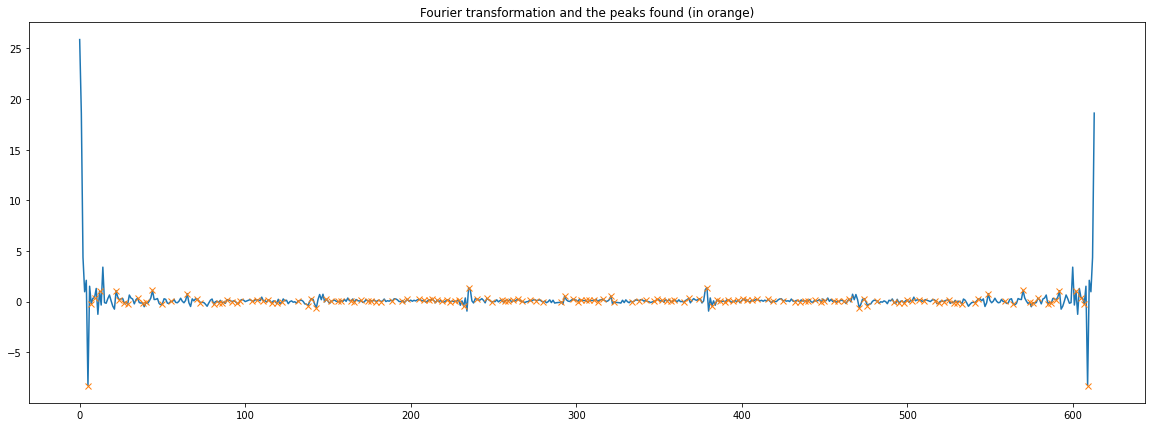

In [0]:
plt.figure(figsize=(20,7))
plt.plot(xtrain_fft[1278,:])
plt.plot(peaks, xtrain_fft[1278,:][peaks], "x")
plt.title("Fourier transformation and the peaks found (in orange)")
plt.show()

### 3.5.8. Autocorrelation

We compute the autocorrelation curve of each observations. This transformation did not give good results. I did not know how to interpret the autocorrelation curve for our problem.

In [0]:
xtrain_corr = xtrain.copy()
for i in range(xtrain_corr.shape[0]):
  xtrain_corr[i] = np.correlate(xtrain_corr[i,:], xtrain_corr[i,:], mode='full')[:61440]

In [0]:
xtest_corr = xtest.copy()
for i in range(xtest_corr.shape[0]):
  xtest_corr[i] = np.correlate(xtest_corr[i,:], xtest_corr[i,:], mode='full')[:61440]

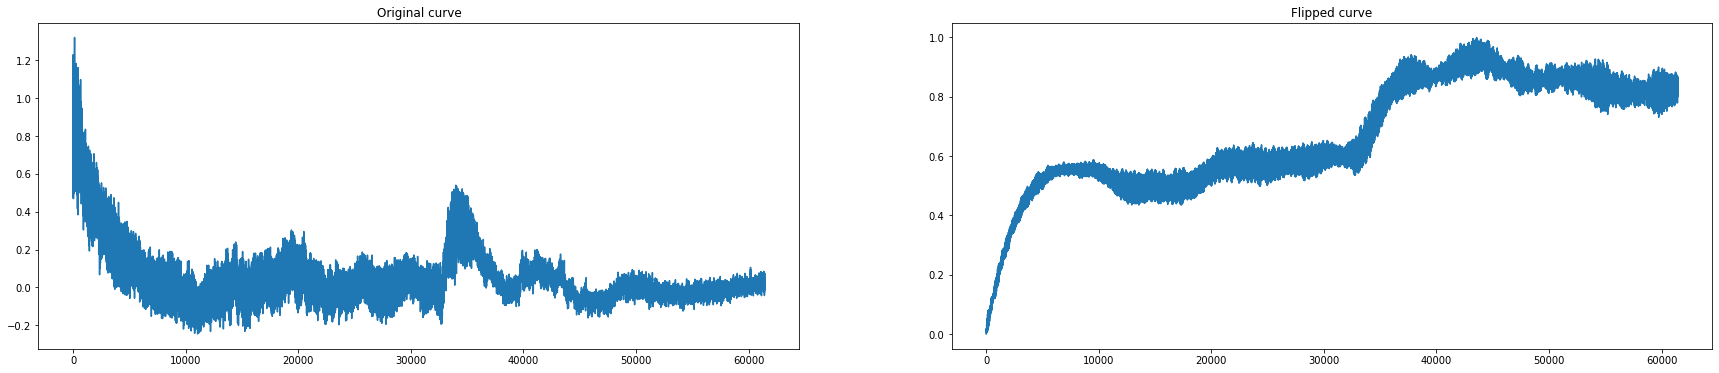

In [0]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
plt.title("Original curve")
plt.plot(xtest[0,:])

plt.subplot(1,2,2)
plt.title("Flipped curve")
plt.plot(xtest_corr[0,:] / float(xtest_corr[0].max()))

plt.show()

### 3.5.9. Hurst

We compute the Hurst equation of each observation.

In [0]:
from hurst import compute_Hc, random_walk

# Evaluate Hurst equation
H = []
for i in range(xtrain.shape[0]):
    try:
      H.append(compute_Hc(xtrain[i,:], kind='random_walk', simplified=True)[0])
    except:
      H.append(-1)
      print("Error at position: ", i)
df_H_train = pd.DataFrame(H)
# As the computation is slow, we save the values into a CSV
df_H_train.to_csv(ROOT + "H_train.csv", sep=";")
print("train exported !")

H = []
for i in range(xtest.shape[0]):
    try:
      H.append(compute_Hc(xtest[i,:], kind='random_walk', simplified=True)[0])
    except:
      H.append(-1)
      print("Error at position: ", i)
df_H_test = pd.DataFrame(H)
df_H_test.to_csv(ROOT + "H_test.csv", sep=";")
print("test exported !")

### 3.5.10. Gradient

We compute the gradient of the observation, in order to study the variations of the curve. In order to have cleaner variations, we do it on the dataset transform by the average rolling.

In [0]:
xtrain_gradient = np.gradient(xtrain_rolling[:,1000:-1000], axis=1)[:,1:]
xtest_gradient = np.gradient(xtest_rolling[:,1000:-1000], axis=1)[:,1:]

### 3.5.11. Wavelet transform

We extract the 14 main wavelets of each observations and compute for each wavelet 8 statistics. This gives a dataset describing each main wavelet of the observations, but it gives bad results. The resulting dataset has the inconvenient to have many dimensions (14 * 8 = 112.

In [0]:
def compute_wavelet_feat(xset):
  xset_feat = pd.DataFrame(columns=[])
  stat1 = np.min(xset)
  stat2 = np.max(xset)
  stat3 = np.mean(xset)  
  stat4 = np.median(xset)
  stat5 = np.mean(np.sqrt(xset**2)) 

  mean_crossings = []
  mean_crossing_indices = np.nonzero(np.diff(np.array(xset) > np.nanmean(xset)))[0]
  stat6 = len(mean_crossing_indices)

  percentiles = np.percentile(xset, [30,75]) 
  stat7 = percentiles[0]
  stat8 = percentiles[1]
  
  return [stat1,stat2,stat3,stat4,stat5,stat6,stat7,stat8]

In [0]:
xtrain_wave = np.zeros((xtrain.shape[0], 112))
for i in range(xtrain_wave.shape[0]):
  list_coeff = pywt.wavedec(xtrain[i,:], "db4")
  features = []
  for coeff in list_coeff:
    features += compute_wavelet_feat(coeff)
  xtrain_wave[i] = features

In [0]:
xtest_wave = np.zeros((xtest.shape[0], 112))
for i in range(xtest_wave.shape[0]):
  list_coeff = pywt.wavedec(xtest[i,:], "db4")
  features = []
  for coeff in list_coeff:
    features += compute_wavelet_feat(coeff)
  xtest_wave[i] = features

### 3.5.12. KernelPCA

We perform a kernel PCA transformation. It didn't do as well as the classic PCA.

In [0]:
from sklearn.decomposition import KernelPCA

# KernelPCA model
kernel_pca = KernelPCA(kernel='rbf', random_state=RANDOM_STATE) #(, kernel='linear', gamma=None, degree=3, coef0=1, kernel_params=None, alpha=1.0, fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, copy_X=True, n_jobs=None)
kernel_pca.fit(xtrain) 

# KernelPCA transform
xtrain_kernel_pca = kernel_pca.transform(xtrain)
xtest_kernel_pca = kernel_pca.transform(xtest)
print(xtrain_kernel_pca.shape)

(1677, 1676)


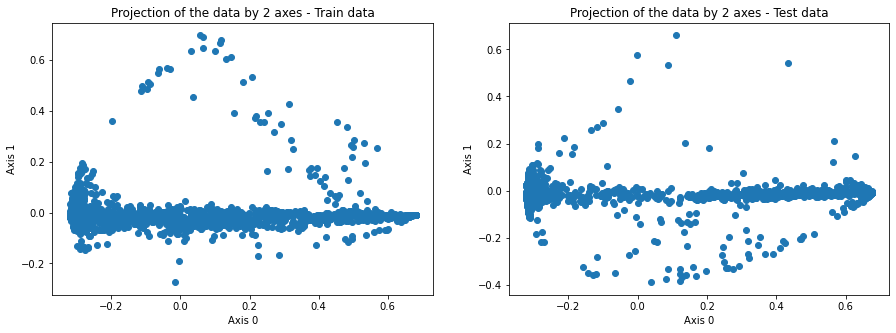

In [0]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(xtrain_kernel_pca[:,0], xtrain_kernel_pca[:,1])
plt.title("Projection of the data by 2 axes - Train data")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

plt.subplot(1,2,2)
plt.scatter(xtest_kernel_pca[:,0], xtest_kernel_pca[:,1])
plt.title("Projection of the data by 2 axes - Test data")
plt.xlabel("Axis 0")
plt.ylabel("Axis 1")

plt.show()

-------
# 4. Models

## 4.1. OneClassSVM

We implement the OneClassSVM algorithm ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)). It is the algorithm that gives the best results.

In [0]:
%%time

# Fit the low-dimensional method
clf = OneClassSVM(tol=0.001, nu=0.003, gamma='scale').fit(xtrain_pca_feat) #(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

# Calculate anomaly score on the (PCA-transformed) test data
sscore = -clf.score_samples(xtest_pca_feat)
print(sscore[:100])

[-0.22797417 -0.28452556 -0.38608058 -0.26901935 -0.28646119 -0.29815064
 -0.36783664 -0.38577952 -0.31276554 -0.11659695 -0.38182013 -0.29508146
 -0.29580843 -0.28438344 -0.29716155 -0.27619288 -0.28935322 -0.23021829
 -0.28667638 -0.29949574 -0.38284834 -0.30373123 -0.29807178 -0.38069738
 -0.         -0.29626161 -0.28983242 -0.29142922 -0.38930492 -0.29161591
 -0.3107671  -0.28869748 -0.25861661 -0.28014419 -0.24274442 -0.39280165
 -0.29820983 -0.         -0.38611472 -0.30447981 -0.38557432 -0.3012707
 -0.38726926 -0.26052612 -0.27549047 -0.28578681 -0.34878851 -0.38834177
 -0.2848087  -0.35918244 -0.31124084 -0.38741472 -0.28699339 -0.33732586
 -0.16310649 -0.298524   -0.2861597  -0.31631402 -0.26793944 -0.29701826
 -0.25414903 -0.38878871 -0.37876049 -0.28898487 -0.30556088 -0.29757389
 -0.13194934 -0.29839224 -0.38208423 -0.38462446 -0.         -0.29111012
 -0.34672924 -0.37787872 -0.16248737 -0.38986652 -0.27716604 -0.29564899
 -0.37154764 -0.2996782  -0.30650725 -0.27012322 -0.

## 4.2. Ohter models tested

### 4.2.1. Local Outlier Factor

We first implemented the local outlier factor algorithm ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)). It gives good results for a first approach (score 0.74 with the initial PCA).

In [0]:
# Fit the LOF model
model_lof = LocalOutlierFactor(n_neighbors = 5, contamination = 'auto', novelty = True)
model_lof.fit(xtrain_pca_feat)

# Calculate anomaly score on the (PCA-transformed) test data
sscore = -model_lof.score_samples(xtest_pca_feat)
print(sscore[:100])

[ 3.15921113  1.82600175  1.39716518  2.00201863  1.74013489  1.28413078
  1.68453558  1.20794365  1.63141578  3.00051392  1.27273543  1.04919725
  1.10298079  2.53297772  1.39528883  1.64188718  1.42603521  2.77134608
  1.31473028  1.26197571  2.22101084  1.80222165  1.51099923  1.23730814
 12.32764939  1.02121643  1.76236814  0.99600358  1.19447191  1.99449428
  1.41655149  1.30113078  2.2475717   1.51208857  3.0485059   1.49230233
  1.29389741  8.59989845  2.31845804  1.58323442  1.67653779  1.53638114
  1.14609606  2.24981637  2.33109518  2.02170687  1.16305685  1.01328506
  1.28137443  1.28185483  1.49725322  1.08093029  1.52332911  1.13257109
  2.58186909  1.38778057  1.11514988  1.1655952   1.41707347  1.57442707
  2.98743555  1.01207357  2.09067607  1.17594266  1.30883877  1.58317006
  3.11567245  1.21824429  1.09066166  1.01643355 13.45671267  1.07562162
  1.47888801  1.21043736  2.79184147  1.04873892  1.80891326  1.72906784
  1.18936525  1.59417457  0.98609433  4.38854495  1

### 4.2.2. Isolation Forest

We then tried the isolation forest ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)).

In [0]:
clf = IsolationForest(n_estimators=3000, max_samples=1677, max_features=13, random_state=RANDOM_STATE) # (n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, behaviour='deprecated', verbose=0, warm_start=False)
clf = clf.fit(xtrain_feat)

sscore = -clf.score_samples(xtest_feat)
print(sscore[:100])

[0.37035701 0.35366414 0.40921087 0.34874495 0.34833703 0.34761468
 0.41306444 0.41221268 0.35545212 0.5973698  0.41391252 0.35244627
 0.35904681 0.35853381 0.36168325 0.3503999  0.36034855 0.36771015
 0.355332   0.34382111 0.36574723 0.3477006  0.34531907 0.3614252
 0.79678991 0.35437422 0.36474375 0.35889902 0.37476162 0.36158909
 0.35910994 0.35017839 0.35581421 0.34723768 0.39039766 0.37944014
 0.35337284 0.79645795 0.37513365 0.42250263 0.36546009 0.36488866
 0.3625178  0.38173065 0.36871147 0.35828446 0.54444514 0.396028
 0.42819252 0.57863787 0.35307263 0.36463101 0.35530804 0.46688145
 0.6460559  0.34245894 0.34989276 0.39243919 0.35103211 0.34366089
 0.36092014 0.40104819 0.38680738 0.35208773 0.36412629 0.34069185
 0.39322732 0.35354968 0.43280457 0.3949738  0.80539423 0.36510477
 0.38498273 0.35458799 0.60227517 0.38057    0.3700942  0.34550642
 0.3926645  0.33979006 0.34987833 0.36430973 0.43255334 0.35449072
 0.34923669 0.35210019 0.37154311 0.34996959 0.35275666 0.3446781

### 4.2.3. Stacking

The idea of the stacking is to load two (or more) submissions, and compute a new score for each observations, based on the scores given by each submissions. It often gives better results than a simple submissions, because two different submissions can find different types of anomalies and be complementary. The submissions must be well selected for this. At the end, the concatenation of the columns from the PCA and the column from the features in one submission gives better results thant by stacking two submissions.

In [0]:
nb_submissions = 206
df_submissions = pd.DataFrame()
for i in range(1, nb_submissions+1):
  df_submissions[str(i)] = np.loadtxt(ROOT + 'submissions/submission_' + str(i) + '.csv', delimiter= ' ')

df_submissions = df_submissions[["145", "93"]]
print(df_submissions.shape)
df_submissions.head()

(2511, 2)


145        93
0 -0.174879  0.962608
1 -0.255895  0.940541
2 -0.349383  0.953053
3 -0.236284  0.945761
4 -0.260649  0.947397

In [0]:
# possibility to scale the scores
scaler = MinMaxScaler()
df_submissions = scaler.fit_transform(df_submissions)

We compute the scores by doing a mean between the scores of the submissions. We also tried to do a mean based on the rank of the scores and not the score itself. We also tried to take the maximal score instead of the mean.

In [0]:
sscore = np.mean(df_submissions, axis=1) # or np.max()
sscore.shape

(2511,)

Other version of the stacking, from two score list (sscore_feat and sscore):

In [0]:
df_submissions = pd.DataFrame()
df_submissions["feat"] = sscore_feat
df_submissions["pca"] = sscore
print(df_submissions.shape)
df_submissions.head()

(2511, 2)


feat       pca
0 -0.074144 -0.174879
1 -0.125680 -0.255895
2 -0.121940 -0.349383
3 -0.129039 -0.236284
4 -0.124893 -0.260649

### 4.2.4. Autoencoders

In contrast with the PCA, the **autoencoder techniques** can perform non-linear transformations with their non-linear activation function and multiple layers and can give better results. Based on this, I implemented an autoencoder to test it. The results were lower than with the PCA. The reason is that the curves are really too different to be well separated by the autoencoder. 

The code is available in a separate notebook, available on the [GitHub repository](https://github.com/xavierbrt/telecom-data-challenge-2) of the project.

-------
# 5. Result analysis

As we cannot have a score without submitting our scores, it is important to analyze the repartition of the scores before submitting them. 

The analysis proved to be really efficient to measure the relevance of a submission.

## 5.1. Evaluate current score

We will display the repartition of the scores. This is important to see if the model has found a few or a lot of anomalies. It is important to have a high step between the high scores and the most common scores, to show that the model has well delimited the anomalies from the non-anomalies. 

Here, 250 observations have the highest score (0), 200 observations have a score between 0 and -0.27), and the following one reach a plateau. It makes me think that there is a lot of anomalies (between 400 and 800).

Some models found not enough anomalies or the anomalies had not a score really higher than the other observations. These models gave lower scores.

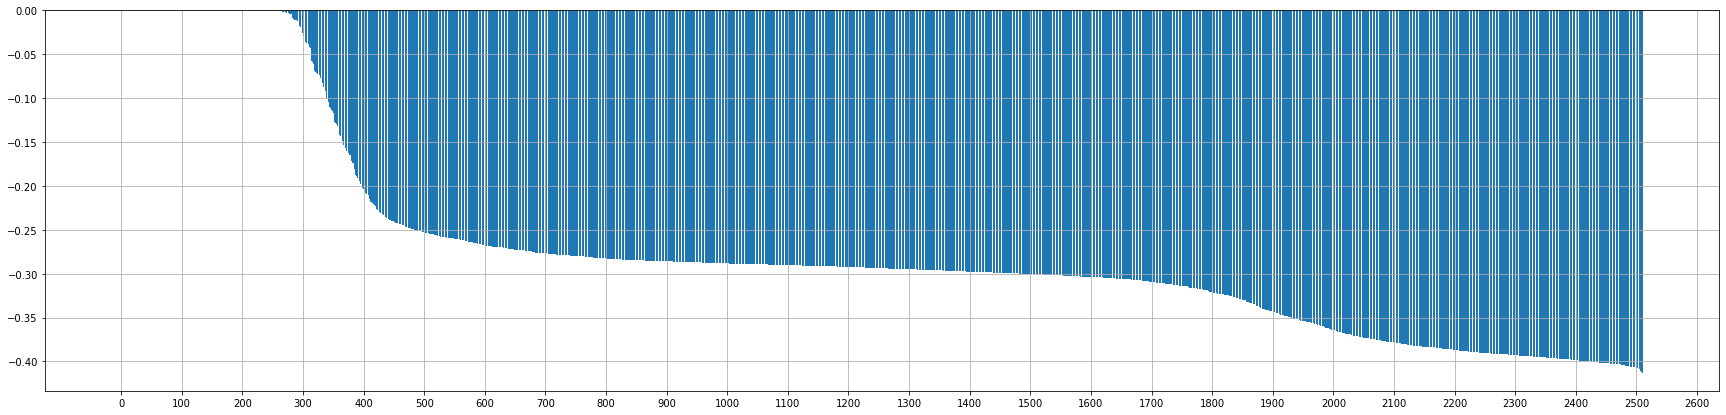

In [0]:
# We store the scores and the index in a dataframe, for a better manipulation
df_res = pd.DataFrame()
df_res["index"] = np.argsort(-sscore) # minus signs are for sorting
df_res["score"] = -np.sort(-sscore)

# We plot the scores, from the highest score to the lowest
plt.figure(figsize=(30,7))
plt.bar(range(df_res.shape[0]), df_res["score"])
plt.xticks(range(0,2700,100))
plt.grid()
plt.show()

We can display the score of a particular observation:

In [0]:
sscore[225]

0.7926562878867379

We display the first 225 observations with the highest anomaly scores.

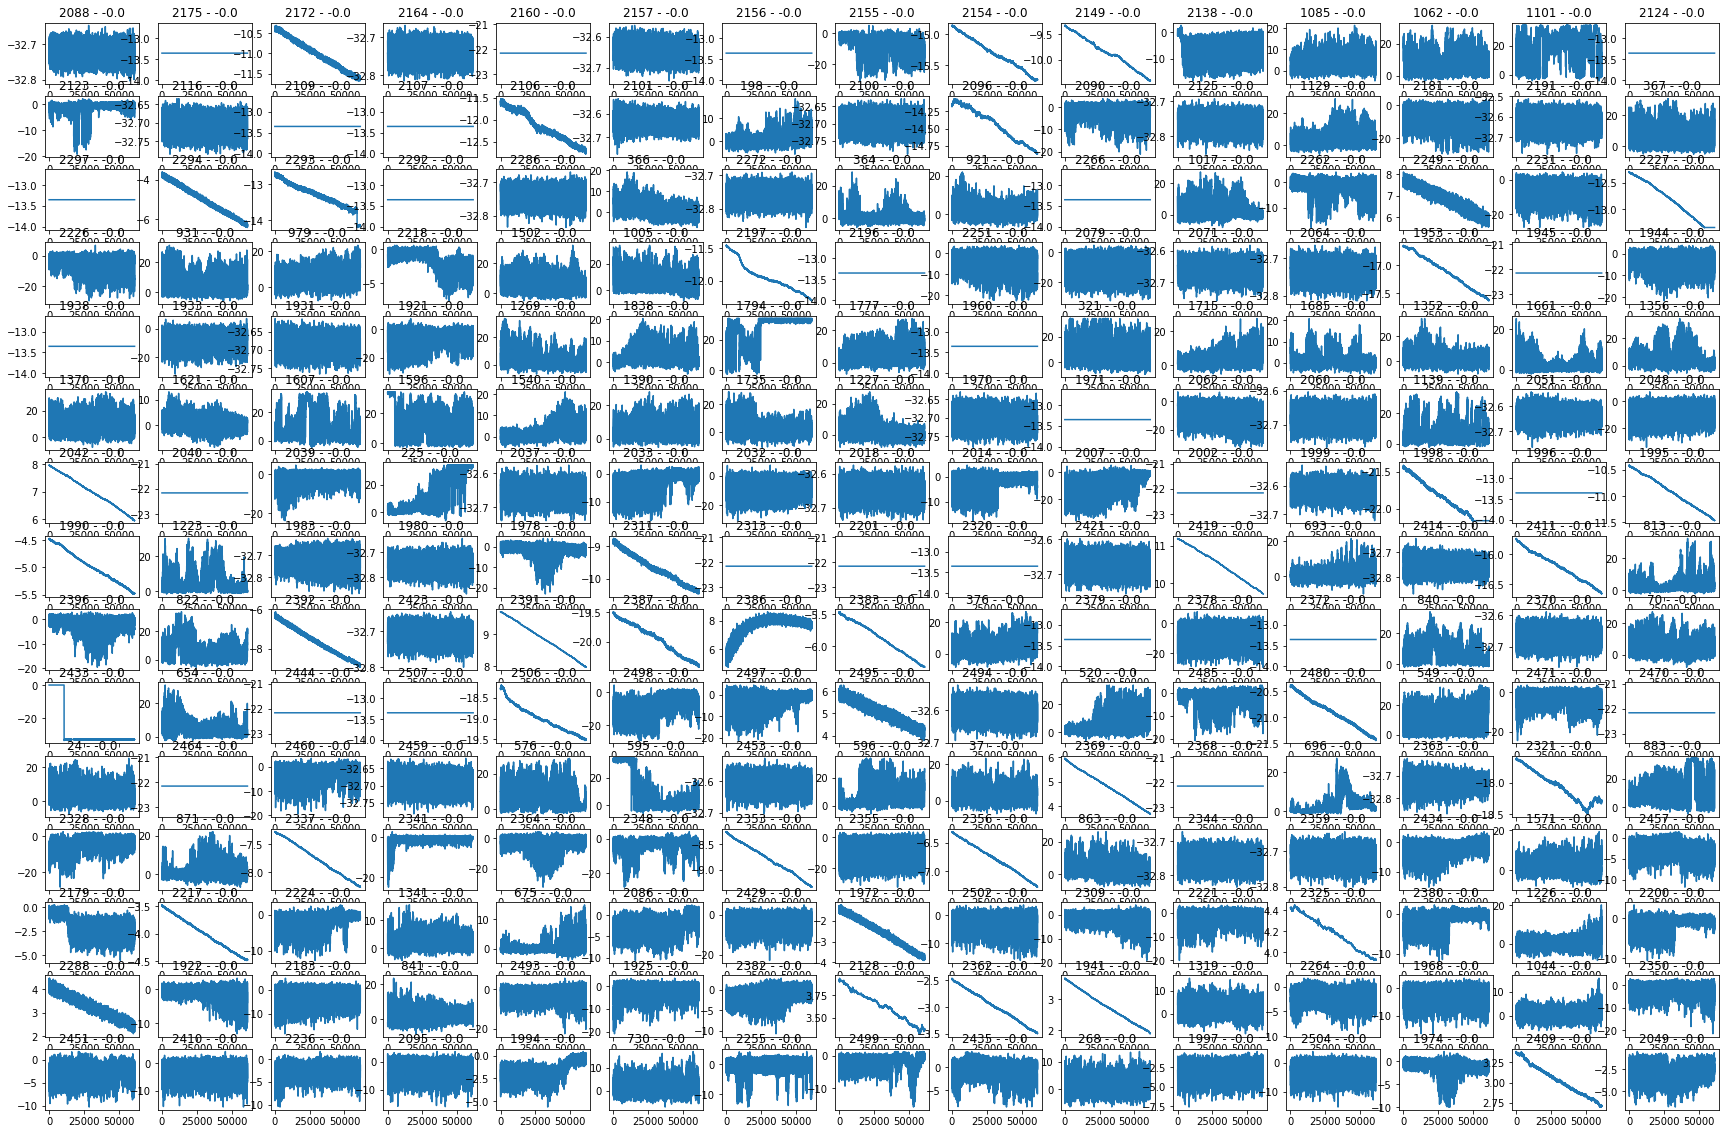

In [0]:
plt.figure(figsize=(30,20))
for i in range(0,225):
  index = df_res["index"].iloc[i]
  plt.subplot(15,15,i+1)
  ax = plt.plot(xtest[index]) #xtest_rolling[index,1000:-1000])
  plt.title(str(index) + " - " + str(round(df_res["score"].iloc[i],4)))
plt.show()

To have a complete view of how the model classified the anomalies, I made a script that sort all of the exported curves (see part 2. Data Exploration) in a folder, based on their scores. In this way, I can see which model detects which types of anomalies.

We display the repartition of the scores:

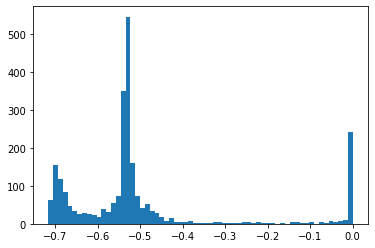

In [0]:
plt.hist(sscore, bins="auto")
plt.show()

## 5.2. Compare past submissions

We load all submissions, and compare the scores given by each submission to each observation:

In [0]:
nb_submissions = 206
df_submissions = pd.DataFrame()
for i in range(1, nb_submissions+1):
  df_submissions[str(i)] = np.loadtxt(ROOT + 'submissions/submission_' + str(i) + '.csv', delimiter= ' ')
df_submissions = df_submissions.rank(axis = 0, method='max', ascending=False)
df_submissions["mean"] = np.mean(df_submissions, axis=1)
print(df_submissions.shape)
df_submissions.head()

(2511, 207)


1       2       3       4  ...     204     205     206         mean
0   289.0   286.0  1935.0   223.0  ...   394.0   395.0   395.0   860.019417
1  2142.0  2087.0   565.0  1890.0  ...   980.0   894.0   894.0  1241.762136
2   936.0  2321.0  1882.0  1019.0  ...  2196.0  2137.0  2137.0  1595.961165
3   663.0   658.0    51.0   544.0  ...   696.0   631.0   631.0  1076.927184
4  1827.0  1713.0   239.0  1765.0  ...   910.0   882.0   882.0  1288.694175

[5 rows x 207 columns]

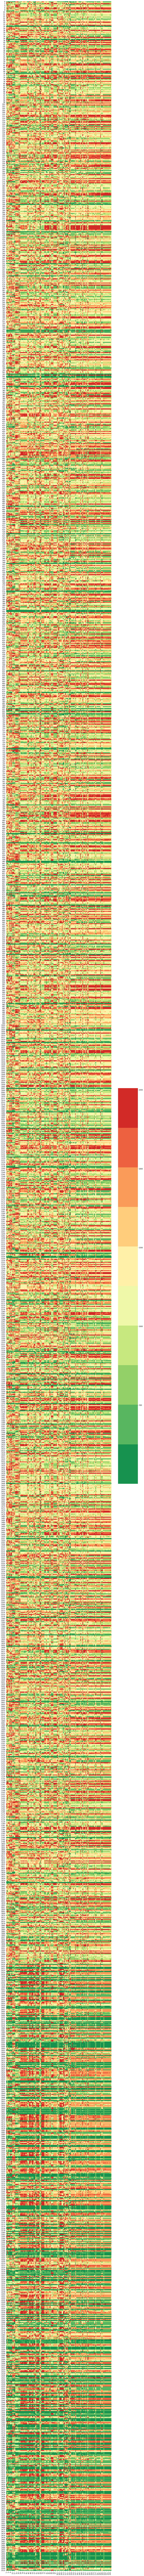

In [0]:
plt.figure(figsize=(15,300))
sns.heatmap(df_submissions, cmap=sns.color_palette("RdYlGn_r", 10))
plt.show()

# 6. Submission

In [0]:
# Save the anomaly scores to file
print(sscore.shape)
np.savetxt(ROOT + 'submissions/submission_206.csv', sscore, fmt = '%1.6f', delimiter=',')

(2511,)


### Submissions 0-100

* 1: fichier de base (score: 0.706630761244)
* 2: idem mais PCA sur tout le jeu de données (score: 0.714321690336)
* 3: idem mais PCA sur tout le jeu de données aussi pour calculer xtrain_fpca (score: 0.52)
* 4: retour v1 mais avec n_components = 8 pour la pca
* **5**: retour v1 mais avec n_components = 10 (je pensais avoir soumis pareil que le 2) (0.746458897252)
        -> Le seed influe beaucoup sur la PCA
* 6: idem, seed à 261 (0.70)
* 7: idem, seed à 8 (0.7072)
* 8: idem, seed remis à RANDOM_STATE (261) et n_neighbors = 20 pour LFO (0.721539854401)
* 9: xtest au lieu de xtrain, n_components = 5 et n_neighbors = 20 (0.710120879528)
* 10: idem mais n_components = 10 (0.710219758488)
* 11: xconcat (xtrain + xtest) pour le train, n_components = 10 et n_neighbors = 20 (0.721539854401). Même score avec xconcat que xtrain (normal car on prenait que les 100 premières rows pour fit le Lof)
* 12: OneClassSVM toute simple, gamma= auto (0.693180132745)
* 13: Lof trained with xtest and score obtained with *negative_outlier_factor_* (0.608454769056)
* 14: idem, but with PCA (5 components) trained on xtest (0.637194556713)
* 15: idem but PCA 10 components (0.608454769056)
* 16: idem but PCA 3 components (0.63060365605)
        -> 5 components is better than 10 and 3 on PCA
* 17: PCA with xconcat (n_components = 5), LFO with xtest (0.58350946148)
* 18: PCA with xconcat (n=5) and LFO on xconcat (extraction of the last scores, corresponding to xtest part) (0.593244404069)
* **19**: **soumission de base**: PCA (n=11) fittée sur tout xtrain, puis appliquée sur xtrain et xtest puis LFO (n=5) (0.592950857157)
* 20: idem sauf que LFO (n=10) (0.603503096147)
* 21: idem que 19, mais avec un score très bas mis pour les 30 premiers résultats (courbes homogènes mais valeurs vers -38) (0.561155091648)
* 22: erreur (même soumission que 21)
* 23: même principe que 21 mais en enlevant cette fois les courbes toutes plates, à 0 (0.552676220846)
* **24**: **dataframe created from features** (min, max, mean, etc.) (0.714724931094)
* 25: idem que 19
* 26: idem que 19 mais PCA et modèle fit sur xtrain[100:] (0.611723954664)
        -> Meilleur score obtenu, peut-être que s'entraîner sur qu'une partie des observations améliore le modèle
* **27**: comme la soumission de base (sauf PCA = 10), mais avec les colonnes ajoutées des features (donc 10+13 colonnes) (0.722596623284)
* **28**: idem que 24 mais sans les percentiles. D'ailleurs LFO n=5 (0.733363615015)
* **29**: idem que 28 mais LOF entraîné sur xtrain[1,131] (0.774044582051)
      -> Le dataframe des features donne des meilleurs résultats que le dataframe de base réduit avec une PCA
* 30: idem mais ajout de start (moyenne des 100 premières valeurs), end (moyenne des 100 dernières valeurs), progression (end - start) (0.771676121967)
* 31: idem mais sans start et end (0.771189452087)
* 32: idem but without progression, and var added (0.76720339402)
* 33: idem but keep var and remove std (0.767444411485)
* **34**: idem but keep only min, max, mean (0.775822858344)
* 35: idem, only max and mean (0.751178822599)
* 36: idem, only min, max, mean, xtrain[:100], to compare with sub 34 (0.76263024213)
* 37: idem, but xtrain[1:289] and LOF (n=100) (0.707186955393)
* 38: idem, but LOF (n=5) (0.761964354135)
      -> xtrain[1,131] (0.77) est mieux que xtrain[:100] (0.762) et xtrain[1:289] (0.761)
* 39: idem que 34, et concatenation avec une PCA (n =10) sur tout le jeu de données. Donc 13 colonnes au total (0.769823686455)
* 40: error
* 41: idem que 34, median added (0.77493912764)
* 42: moyenne mobile de 200, on retire les 300 premières valeurs à gauche et à droite puis on fait le set de features (min, max, mean) puis LFO (0.730012545268)
* 43: idem pour la moyenne mobile, mais on retire les 400 premières et dernières valeurs, puis on fait une PCA (n = 7) puis LFO (0.741069993944)
* 44: idem mais moyenne mobile sur 1000 (ça trace des courbes bien distinctes), on retire les 1000 premières et dernières puis PCA (n = 10) puis LFO (0.740401015981)
* **45**: idem que 44 mais PCA (n = 4) (0.752918474298)
-----
* 46: xtrain_feat (idem que 34), tout xtrain utilisé, OneClassSVM params par défaut (0.688407677951)
* 47: idem mais xtrain[1:131] (0.698414537679)
* 48: idem que 46, mais OneClassSVM est entraîné sur xtrain_feat et xtest_feat concaténés (0.682379151371)
* **49**: **Stacking** (sommes) des scores des submissions 34 (features avec min, max, mean) et 45 (rolling 1000, PCA (n=4)) avec à chaque fois xtrain[1:131]  LOF (n=5)  recalculées **(0.781531573288)**
* 50: idem mais ajout de la solution de base, presque 19 (PCA (n=10) sur les données normales puis LFO avec xtrain[1:131]) dans le stacking (0.753622986886) -> la solution de base n'est pas très bonne, ne plus l'utiliser
* 51: idem que 49 mais ajout de la soumission 46 (xtrain_feat puis OneClassSVM sur tout xtrain_feat) (0.752740801167)
      -> Le stacking améliore le résultat (avec des modèles bien choisis)
* 52: slicing de chaque échantillon en 3, conversion en features, LFO, déslicing en prenant le score max des 3 sections pour chaque échantillon (0.716598996379)
* 53: idem mais sum au lieu de max (0.727539026289)
      -> le slicing testé est pas top
* 54: idem que 49 mais le stacking est fait en prenant le max des deux résultats et non la somme (0.777611949522)
* 55: **xtrain without outliers**. Modèle features classique (comme sub 34), mais LOF entraîné sur xtrain sans ses outliers (on a enlevé les 200 valeurs les moins normales de xtrain grâce à un LOF dédié) (0.743481713572)
* 56: pour vérification, même soumission que la 34, mais LOF sur tout xtrain (0.741090078732)
* 57: idem que 55 mais en en enlevant 1000 au lieu de 200 (0.716169490897)
* 58: scaler les données (par une formule), puis features (comme sub 34), puis LFO sur tout (0.685665331801) -> Mauvais score pcq maintenant la moyenne est à quasi 0 pour tout le monde ?
* 59: idem mais pca (N=6) au lieur de features (0.475198375913) lol
-------
* 60: Isolation forest (paramètres de base), sur xtrain_feat (min, max, mean), entraîné sur tout xtrain_feat (0.741623098125)
* 61: idem mais xtrain_feat[1:131] (0.704803045472)
* 62: idem que 60, mais avec ces feats: ["min", "max", "mean", "std", "etendue", "median", "q1", "q2", "q3"] (0.744898463668)
* 63: idem mais n_estimators=1000 (0.727134240548)
* 64: idem mais warm_start=True (0.727134240548)
* 65: idem que 60 mais feat: "min", "max", "mean", "std", "etendue", "median" (0.7189829063)
* 66: Isolation forest (paramètres de base), sur xtrain_pca (n=9), entraîné sur tout xtrain_pca (0.662427231266)
--------
* 67 KernelPCA (n_components=9, kernel='rbf'), puis LFO sur tout xtrain (0.626883335187)
* 68: idem KernelPCA mais n_components laissé par défaut (il a sorti 1776 colonnes) (0.35931841497). Il a sorti en plus grandes anomalies des courbes tout à fait normales
* 69: idem mais Isolation forest plutôt que OLF. Les courbes sorties en anomalies sont composées de motifs rares (top !) mais mélangés à des motifs communs) (0.318424240177)
* 70: idem que 62 + ajout de la colonne surface (0.733596907561)
-------
* 71: OneClassSVM avec xfeat ("min", "max", "mean", "std", "etendue", "median", "q1", "q2", "q3" + SURFACE) (0.679109965763). Les 85 premières valeurs avaient le même score d'anomalie (0 pile)
* 72: OneClassSVM avec xfeat ("min", "max", "mean", "var",  "median"), train sur tout xfeat (0.688528186683)
* 73: OneClassSVM avec xfeat (min, max, mean) - même submission que 46 (0.688407677951)
* 74: j'ai resoumis 46, j'ai obtenu un score différent (0.688407677951). J'avais fait une erreur à la 46
* 75: j'ai resoumis 60, j'ai obtenu le même score
* **76**: OneClassSVM avec xfeat (tol=0.001, nu=0.005, gamma='scale') **(0.802028872656)**
* 77: OneClassSVM avec xfeat (tol=0.001, nu=0.0005, gamma='scale') (0.801778585289)
* **78**: idem que 76 avec xfeat + colonne surface (0.801489673329)
--------
* 79: Fusion d'algos (5, 34, 45, 76 # PCA + LFO, features + LFO, moyenne mobile + PCA, feat + OneClassSVM), rank puis mean (0.801278010555)
* 80: idem, mais que avec les algos 5 et 76 (0.796990680658)
* 81: idem que 79, mais que les algos 34, 45, 76 (0.804374157984)
* **82: Fusion d'algos** (34, 45, 76), MinMaxScaling des scores puis mean **(0.809047733818)**
* 83: idem, mais max au lieu de mean (0.802109211811)
* 84: OneClassSVM avec xfeat ("min", "max", "mean", "var", "median"), tout xfeat (tol=0.001, nu=0.003, gamma='scale') (0.802031962624)
* **85**: idem que 84, mais concatenation de xfeat avec xpca (au prealable rolling de 1000, PCA n=4) **(0.828806530955)**
* 86: idem mais OneClass avec tol=1 (0.65244200131)
* 87: idem que 85, mais gamma = 0.3 (0.763555687394)
* 88: fursion d'algos (idem 82) mais algos 34, 45 et 85 (0.82645815566)
---------
* 89: Autoencoder (hidden_neurons =[6000, 100, 2, 100, 6000]) sur xtrain [:500,:6000] (0.563356693488)
* 90: Autoencoder [614, 100, 2, 100, 614] sur xtrain (2511, 614) - 614 obtenu par réduction de données par moyennage (0.657008973266)
* 91: Autoencoder [614, 200, 100, 10, 100, 200, 614] (et validation size=0.3) sur xtrain (1677, 614) (0.65733650982)
* 92: Autoencoder [6144, 200, 100, 10, 100, 200, 6144] sur xtrain (1677, 6144) (0.558814441272)
* 93: SO_GAAL (paramètres par défaut) sur xtrain (1677, 6144) (0.666723831065)
---------
* 94: OneClassSVM (tol=0.001, nu=0.005, gamma='scale') sur xtrain ("min", "max", "mean", "var", "median", "p5", "p95") (0.804018811722)
* 95: erreur (idem 94)
* 96: idem 94, mais p30 et p70 au lieu de p5 et p95 (0.805103390312)
* 97: idem mais sans la médiane (0.803305029231)
* 98: idem mais sans la moyenne non plus (0.801387704401)
* **99**: idem mais on remet la moyenne et on enlève la var **(0.810571087792)**
---------


### Submissions 100-200

* 100: OSVM, avec les X transformé par maxabs_scale (certaines courbes comme la xtest 2125 sont chelous) puis xfeat (min, max, median, 30, 70) (0.73664825046)
* 101: xtrain_rebin (614 points) puis envoyé comme ça à OSVM (0.668398593447)
* 102: erreur (idem que 101)
* 103: xtrain_rebin (614 points) puis xfeat (min, max, mean, 30, 70) (0.668398593447) (0.779278986985)
* 104: rebin puis PCA (4) puis OSVM (0.714032778375)
-> Le rebin donne des scores moins bons
----
* 105: xfeat ('min', 'max', 'mean', 'median', 'var', 'std', 'etendue', 'skewness', 'kurtosis', 'p10', 'p30', 'p70', 'p90') puis OSVM (tol=0.001, nu=0.005, gamma='scale') (0.76434980904) -> Fait ressortir des courbes toutes plates avec 1 ou 2 pics au milieu. **Bien pour du stacking**
* 106: idem, mais isolation forest(n_estimators=500, max_features=10) au lieu de OSVM (0.723250151408)
* 107: idem mais isolation forest (n_estimators=500, max_samples= 500, max_features=10) (0.729026845638)
* 108: idem mais isolation forest (n_estimators=1000, max_samples=1000, max_features=10) (0.738060365605)
* 109: idem mais isolation forest (n_estimators=3000, max_samples=3000, max_features=13) (0.74023570272)
* 110: idem mais sur xfeat**2 (0.656843660005)
* 111: idem mais sur xfeat**3 (0.642946531202)
* 112: idem que 105 mais OSVM (tol=0.001, nu=0.005, gamma='auto') (0.721694352775)
* 113: idem 105 mais xfeat puis xpca (3) (0.564252784061)
* 114: idem 105 mais xfeat ('min', 'max', 'etendue', 'skewness', 'kurtosis', 'p30', 'p70') (0.746316758748)
* 115: idem 105 mais xfeat ('min', 'max', 'mean', 'skewness', 'p30', 'p70') (0.792096172148)
------
* 116: xtrain_rebin puis xtrain_fft puis xtrain_peaks puis OSVM (0.538042134797)
* 117: idem mais ajout d'une pca (2) avec OSVM (0.657858714326) - détecte que 300 anomalies mais dont certaines courbes rares (cassures, etc.) - **peut être intéressant avec l'ajout de colonnes feat**
* 118: idem mais PCA (8) (0.71185744126) - **idem**
* 119: idem + concatenation de xfeat (min, max, mean p30, p70) (0.788131743854)
* 120: idem 118 mais on prend que les 312 premières colonnes de xtrain_peaks avant la PCA (car les colonnes sont symétriques) (0.713037808842)
* 121: idem mais PCA (5) (0.704321010543)
-------
* 122: xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', 'p30', 'p70') puis OSVM (0.558148553277) - **Très peu d'anomalies repérées, mais anomalies très intéressantes (courbes inclinées, courbes cassées)**
* 123: xfeat ('min', 'max', 'mean', 'rms', 'p30', 'p70') puis OSVM **(0.810592717565)**
* 124: xfeat ('min', 'max', 'rms', 'p30', 'p70') osvm (0.807583089226)
* 125: xfeat (juste mean_crossings haha) OSVM (0.625027809707) - **même conclusion que 122. Peut-être préférer 125 à 122**
* 126: idem mais IsolationForest(n_estimators=3000, max_samples=1677, max_features=1 (0.579120162656)
* 127: idem mais LocalOutlierFactor(n_neighbors = 5, contamination = 'auto', novelty = True) (0.563398408049)
* 128: même idée que 85 (avec juste ajout de rms normalement), OneClassSVM (tol=0.001, nu=0.005, gamma='scale') avec xfeat ('min', 'max', 'mean', 'rms', 'p30', 'p70'), tout xfeat  et concatenation de xfeat avec xpca (au prealable rolling de 1000, PCA n=4) (0.82655703462)
-------
* 129: soumission 128 + on prend les anomalies avec les 120 plus haut scores de la soumission 125 et on les met automatiquement à 0 (qui correspond au meilleur score de la soumission 128) (0.820397184422)
* 130: idem, mais on prend que les anomalies 58:120, pour éviter les toutes plates et les plates inclinées (0.820397184422)
* 131: idem mais au lieu de mettre à 0, je met à -1 (donc pas anomalies) les anomalies [:58] (les plates et plates inclinées) (0.749208968322) -> les plates et plates inclinées sont bien des anomalies
* 132: idem 131 mais au lieu de mettre à 0, on les met à 1 (donc les plus anormales) (0.82655703462) - Même score que 128 - normal car les 58 mis à 1 avaient déjà un score de 0 (sauf un)
* 133: idem mais les 150 premiers sont mis à 1 (0.809736796569)
* 134: idem mais que les 120 premiers (0.819131842733)
* 135: idem mais en prenant 85 et en mettant à 1 des courbes plates à des pics très fin très haut (0.821025992807)
-------
* 136: xfeat ('min', 'max', 'mean', 'rms', 'hurst', 'p30', 'p70') OSVM (0.810200291693)
* 137: xfeat ('hurst') (0.561963118148) - même conclusion que 125
* 138: soumission 85 + on prend les anomalies avec les 135 plus hauts scores de la soumission 137, que l'on met à 1 (0.808573423808)
* **139**: xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', 'hurst', 'p30', 'p70') avec mean_crossings normalisé avec StandardScaler et OSVM (tol=0.001, nu=0.005, gamma='scale') **(0.857998998851)**
* 140: idem mais OSVM (tol=0.001, nu=0.003, gamma='scale') **(0.85817203703)**
* 141: idem mais OSVM (tol=0.001, nu=0.001, gamma='scale') (0.857793516012)
* 142: idem mais OSVM (tol=0.0001, nu=0.003, gamma='scale') (0.857998998851)
* 143: idem 140 + ajout colonnes xrolling[1000] puis PCA (4) **(0.886296921156)**
* 144: stacking 105 + 143 (scaling puis mean) (0.858260101104)
* 145: idem 143 mais xrolling[300] **(0.886647632467)**
* 146: idem que 145, sauf que OSVM sur feat et OSVM séparée sur pca, puis stacking  (scalé puis mean) (0.880989901986) 
          -> Il vaut mieux calculer les scores avec les colonnes concaténées que à part 
* 147: juste PCA: rolling, on enlève les 300 extremités puis PCA (0.733490303682) -> donc rolling est plus efficace que rebin
* 148: stacking 145 et 93 (0.847312346274)
* 149: idem que 140 mais xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', 'hurst', 'p5', 'p25', 'p75', 'p95') puis OSVM (0.856265527087)
* 150: idem mais xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', 'hurst', 'p5', '30','70', 'p95') (0.856750651983)
* 151: ideam mais xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', 'hurst', '30', '70') et StandardScaler sur toutes les colonnes, pas que hurst (0.685651426947)
* 152: idem 140, mais le scaler de mean_crossings a été fit que sur xtrain (0.802646866155).
* 153: idem 140 mais sans mean_crossings ('min', 'max', 'mean', 'rms', 'hurst', '30', '70') (0.810484568702)
* 154: idem 140 mais sans hurst ('min', 'max', 'mean', 'rms', 'mean_crossings', '30', '70') (0.858346620194)
* 155: idem 140 mais sans hurst ni mean ('min', 'max', 'rms', 'mean_crossings', '30', '70') (0.855659893458)
* 156: idem 140 mais sans hurst et ajout median **('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', '30', '70')** **(0.859988937916)**
----------
* 157: idem 147 mais vertical flip de xtrain puis rolling puis+ PCA (4) (0.748061045398) **-> Le flip améliore la PCA**
* 158: idem 156 mais vertical flip de xtrain puis xfeat (0.862264698975)
* 159: idem 145, concatenation xfeat (158) + xpca (157), avec avant flip de xtrain (0.886281471319)
* 160: idem 157 mais PCA (9) (0.708863262758)
* 161: idem 157 mais flip aussi de xtest, puis moyennage des scores à la fin (0.748059500414)
* 162: idem 161 mais max au lieu de mean à la fin (0.748281978074)
* 163: idem 145, mais aussi flip de xtest puis reconcaténation des scores à la fin par max (0.886194952229)
* 164: idem 143 mais ajout median: xfeat ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', '30', '70') + xpca après xrolling[300] **(0.886692436996)**
* 165: idem, mais ajout skewness et kurtosis: xfeat ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', 'skewness', 'kurtosis', '30', '70') (0.856101758809)
* 166: idem mais StandardScaler sur kurtosis (0.879295054816)
* 167: idem mais sans skew ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', 'kurtosis','30', '70') (0.881495111671)
* 168: idem 165 mais sans kurtosis ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', 'skewness','30', '70') (0.880676270286)
* 169: idem 164 mais ajout entropy ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', 'entropy','30', '70') (0.868268505815)
* 170: idem 164 mais RobustScaler au lieu de StandardScaler pour mean_crossings ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', '30', '70') **(0.887230091339)**
* 171: idem mais PowerTransformer cette fois **(0.891460256838)**
* 172: idem mais QuantileTransformer cette fois (0.833836998035)
* 173: idem 171 mais PowerTransformer("box-cox") (0.891460256838)
* 174: idem 171 et PowerTransformer sur les 4 colonnes de la PCA (0.870378953613)
* 175: idem mais StandardScaler cette fois (0.870576711533)
* 176: idem 171 mais dans la PCA (whiten = False) (0.794619130607)
* 177: idem 171 mais PCA (svd_solver="full", random_state=10000) (0.794619130607) - il doit y avoir une erreur quelque part
* 178: xfeat ('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', '30', '70') puis OSVM (pour vérifier) (0.878032803095)
* 179: idem + pca (n_components = 4, whiten=True) rolling 1000 **(0.892157044508)**
* 180: idem mais rolling fait sur 1500 mais pour la pca on reste à 1000 points enlevés (0.891392277553)
* 181: idem mais rolling sur 750 puis on enlève 750 points pour la PCA (0.892017995971)
* 182: idem 179, mais OSVM (tol=0.001, nu=0.0025, gamma='scale') (0.891871222515)
* 183: idem 179, mais OSVM (tol=0.001, nu=0.0035, gamma='scale') (0.891787793392)
* 184: idem 179, mais OSVM (tol=0.001, nu=0.0028, gamma='scale') (0.892087520239)
* 185: idem 179, mais xfeat('min', 'max', 'mean', 'median', 'rms', 'mean_crossings', '30', '75') **(0.892195669102)**
* 186: wavelet, pour le fun (0.633315102525)
* 187: idem 179 mais PCA (9) sur xtrain normal (0.86...)
* 188: idem 179 mais PCA (9) faite sur xtrain_gradient (0.846638733361)
* 189: idem 179 mais PCA (10) faite sur xtrain_gradient qui est fait sur xtrain_rolling (0.837971374541)
* 190: idem 179 mais PCA (5) sur xrebin (0.837971374541)
----------
* 191: classique (179) et xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', '40', '80') (0.892192579134)
* 192: ('mean', 'rms', 'mean_crossings', '5', '40', '80', '95') (0.888608216842)
* 193: ('mean', 'rms', 'mean_crossings', '2', '40', '80', '98') (0.889372983796)
* 194: ('min', 'max', 'mean', 'rms', 'mean_crossings', '40', '80', '95') (0.893598514344)
* 195: erreur
* 196: 'min', 'max', 'mean', 'rms', 'mean_crossings', '40', '80', '98' (0.893606239262)
* 197: 'min', 'max', 'mean', 'rms', 'mean_crossings', '2', '40', '80', '98' (0.**893895151223)**
* 198: 'min', 'max', 'mean', 'rms', 'mean_crossings', '2', '40', '80', '99' (**0.893946135687**)
* 199: 'min', 'max', 'mean', 'rms', 'mean_crossings', '1', '40', '80', '99' (0.893672673563)
* 200: 'min', 'max', 'mean', 'rms', 'mean_crossings', '2', '40', '60', '80','99' (0.893890516272)
* 201: 'min', 'max', 'mean', 'rms', 'zero_crossings', 'mean_crossings', '2','40', '80', '99' (0.892809027649)
* 202: 'min', 'max', 'mean', 'var', 'rms', 'mean_crossings', '2', '40', '80','99' (0.893223083293)
* 203: 'min', 'max', 'mean', 'std', 'rms', 'mean_crossings', '2', '40', '80','99' (0.893765372588)
* 204: 'min', 'max', 'mean', 'etendue', 'rms', 'mean_crossings', '2', '40', '80','99'
* 206: xfeat ('min', 'max', 'mean', 'rms', 'mean_crossings', '2', '40', '80', '99') (osvm gamma=auto) (0.881175300036)